# Comparison and validation for SEASTARex paper

### TODO:
- Pre-process L2 data for each day
- Build dataset of AROME winds and co-located retrieved winds for all flights
- Figure out way to 'interp_like' the X-band data in Xarray for direct comparison with OSCAR

### Structure:
- Colocation with:
    - X-band radar data (17th)
    - MARS2D velocity vectors
    - HF radar velocity vectors (22nd, 26th)
    - AROME winds
- ADCP comparison for 22nd (and 26th?)
- 'Mapping' plots for the Star Pattern flights


Group plots by day


In [1]:
import xarray as xr
import numpy as np
import scipy as sp
from scipy.io import loadmat
from scipy import interpolate, constants, signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
import warnings
import os
import pdb
from scipy.ndimage import binary_dilation as dilate
from scipy.ndimage import binary_erosion as erode
# import warnings

# from shapely.errors import ShapelyDeprecationWarning
# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
# warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def find_mask_outline(mask):
    outline_lon = [np.nan] * 5
    outline_lat = [np.nan] * 5
    a = xr.where(mask==1,
             (mask.GroundRange / mask.GroundRange[-1])
             +(mask.CrossRange / mask.CrossRange[-1]),
            np.nan)
    (xloc, yloc) = np.where(a == np.min(a))
    outline_lat[0] = float(a[xloc,yloc].latitude.data)
    outline_lon[0] = float(a[xloc,yloc].longitude.data)
    (xloc, yloc) = np.where(a == np.max(a))
    outline_lat[2] = float(a[xloc,yloc].latitude.data)
    outline_lon[2] = float(a[xloc,yloc].longitude.data)
    a = xr.where(mask==1,
             (mask.GroundRange / mask.GroundRange[-1])
             +(mask.CrossRange / mask.CrossRange[0]),
            np.nan)
    (xloc, yloc) = np.where(a == np.max(a))
    outline_lat[1] = float(a[xloc,yloc].latitude.data)
    outline_lon[1] = float(a[xloc,yloc].longitude.data)
    (xloc, yloc) = np.where(a == np.min(a))
    outline_lat[3] = float(a[xloc,yloc].latitude.data)
    outline_lon[3] = float(a[xloc,yloc].longitude.data)
    outline_lat[4] = outline_lat[0]
    outline_lon[4] = outline_lon[0]
    return outline_lat, outline_lon


In [3]:
file_paths = ss.utils.readers._set_file_paths()
fig_path = os.path.join(r'D:\OneDrive - NERC\OneDrive - NERC\SEASTAR\SeastarEx\paper\figures','')
SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Device name = LIVPCZG-10
Setting local paths...


# 17th May


In [5]:
version = 'v20230411' # check version
flight = '20220517'
level = 'L2'
# level='L1c'
resolution = '200x200m'
# resolution='window7'
# gmf='mouche12'
gmf='mouche12'
L2_path = os.path.join('D:\data\SEASTAR\SEASTARex\Data\L2',resolution,'')
L1_path = os.path.join('D:\data\SEASTAR\SEASTARex\Data\L1c',resolution,'')
file_paths = ss.utils.readers._set_file_paths()
tracks=['Track_2']
# tracks=['Track_2']
ds_lmout = dict()
ds_lmout_noisy = dict()
ds_L1c = dict()
for track in tracks:
    print('Loading', track)
    ds_lmout[track] = xr.open_dataset(os.path.join(L2_path, flight + '_' + track + '_' + 
                                                    resolution + '_' + gmf + '_lmout.nc'))
    ds_lmout_noisy[track] = xr.open_dataset(os.path.join(L2_path, flight + '_' + track + '_' + 
                                                    resolution + '_' + gmf + '_kp20_rsv20_lmout.nc'))
    ds_L1c[track] = xr.open_dataset(os.path.join(L1_path,
                                                     flight + '_' + track + '_OSCAR_' + resolution + '_L1c.nc'))
print('...done')

Device name = LIVPCZG-10
Setting local paths...
Loading Track_2
...done


# L2 processing
- Sequential: Computes L2 data products using wind data from MeteoFrance AROME and a selected gmf
- Simultaneous: Uses windspeed and direction from MeteoFrance AROME data and removes ambiguity from the ds_lmout datasets using 'closest to truth: wind'

In [6]:
if level=='L1c':
    print('Sequential processing...')
    folder = 'restricted'
    data_type = 'METEOFRANCE_AROME'
    AROME_data_folder = os.path.join(file_paths['aux_path'], folder, data_type,'')
    AROME_dict = dict()
    AROME_file_list = os.listdir(AROME_data_folder)
    for file in AROME_file_list:
        AROME_dict[AROME_file_list.index(file)] =\
        xr.open_dataset(AROME_data_folder + file)
    AROME_winds = xr.concat(list(AROME_dict.values()),dim='time',join='outer')
    del AROME_dict
    ds_L2 = dict()
    sar_pixel_size=8
    rolling_window_metres=8
    rolling_window = int(round(rolling_window_metres/sar_pixel_size))
    
    for track in ds_L1c.keys():
        print('Processing ', track, '...')
        # Generating geophysical data fields for GMF doppler computation
    #     u10 = AROME_winds.u10m.interp(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')\
    #         .interp(latitude=ds_L1c[track].latitude.median(), method='nearest')\
    #         .interp(longitude=ds_L1c[track].longitude.median(), method='nearest')
    #     v10 = AROME_winds.v10m.interp(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')\
    #         .interp(latitude=ds_L1c[track].latitude.median(), method='nearest')\
    #         .interp(longitude=ds_L1c[track].longitude.median(), method='nearest')
    #     wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
        AROME_winds_sel = AROME_winds.sel(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest').isel(height=0)
        windspeed, winddirection = ss.utils.tools.windUV2SpeedDir(AROME_winds_sel.u10m, AROME_winds_sel.v10m)
        winddirection = xr.DataArray(data=winddirection,
                                    dims=windspeed.dims,
                                    coords=windspeed.coords)
        windspeed = windspeed.sel(longitude=slice(-5.2, -5.025), latitude=slice(48.37, 48.55))
        winddirection = winddirection.sel(longitude=slice(-5.2, -5.025), latitude=slice(48.37, 48.55))
        lat, lon = np.meshgrid(windspeed.latitude, windspeed.longitude)
        new_data = interpolate.griddata(points=(-np.ravel(lon), np.ravel(lat)), values=(np.ravel(windspeed)),
                                    xi=(ds_L1c[track].longitude.longitude.values,
                                        ds_L1c[track].longitude.latitude.values),
                                    method='nearest')  
        wind_speed = xr.DataArray(data=new_data, dims=ds_L1c[track].longitude.dims, coords=ds_L1c[track].longitude.coords)
        new_data = interpolate.griddata(points=(-np.ravel(lon), np.ravel(lat)), values=(np.ravel(winddirection)),
                                    xi=(ds_L1c[track].longitude.longitude.values,
                                        ds_L1c[track].longitude.latitude.values),
                                    method='nearest')  
        wind_direction = xr.DataArray(data=new_data, dims=ds_L1c[track].longitude.dims, coords=ds_L1c[track].longitude.coords)
        
        aux = ss.oscar.level1.init_auxiliary(ds_L1c[track].IncidenceAngleImage, wind_speed.data, wind_direction.data)
        # Compute RSC
        rsc = [ss.oscar.level1.compute_radial_surface_current(ds_L1c[track].sel(Antenna=a),aux.sel(Antenna=a),gmf=gmf) 
               for a in ds_L1c[track].Antenna]
        ds_L1c[track]['RadialSurfaceCurrent'] = xr.concat(rsc, 'Antenna',join='outer')
        #L2 Processing
        ds_L2[track] = ss.oscar.level1.init_level2(ds_L1c[track])
        ds_L2[track] = ss.retrieval.level2.compute_current_magnitude_and_direction(ds_L1c[track], ds_L2[track])
        ds_L2[track]['CurrentU'], ds_L2[track]['CurrentV'] =\
        ss.utils.tools.currentVelDir2UV(ds_L2[track]['CurrentVelocity'], ds_L2[track]['CurrentDirection'])
    print('Done...')
elif level=='L2':
    print('Removing ambiguities...')
    AROME_data_folder = os.path.join(file_paths['aux_path'], 'restricted', 'METEOFRANCE_AROME','')
    AROME_dict = dict()
    AROME_file_list = os.listdir(AROME_data_folder)
    for file in AROME_file_list:
        AROME_dict[AROME_file_list.index(file)] =\
        xr.open_dataset(AROME_data_folder + file)
    AROME_winds = xr.concat(list(AROME_dict.values()),dim='time',join='outer')
    del AROME_dict
    ds_L2 = dict()
    for track in ds_L1c.keys():
        print('Processing ',track,'...')
        u10 = AROME_winds.u10m.interp(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')\
            .interp(latitude=ds_L1c[track].latitude.median(), method='nearest')\
            .interp(longitude=ds_L1c[track].longitude.median(), method='nearest')
        v10 = AROME_winds.v10m.interp(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')\
            .interp(latitude=ds_L1c[track].latitude.median(), method='nearest')\
            .interp(longitude=ds_L1c[track].longitude.median(), method='nearest')
        wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
        geo = xr.Dataset()
        geo['EarthRelativeWindSpeed'] = xr.DataArray(data=np.full(ds_L1c[track].Sigma0.shape, wind_speed),
                                   coords=ds_L1c[track].Sigma0.coords, dims=ds_L1c[track].Sigma0.dims)
        geo['EarthRelativeWindDirection'] = xr.DataArray(data=np.full(ds_L1c[track].Sigma0.shape, wind_direction),
                                   coords=ds_L1c[track].Sigma0.coords, dims=ds_L1c[track].Sigma0.dims)
        geo['CurrentVelocity'] = xr.DataArray(data=np.full(ds_L1c[track].RSV.shape, 0),
                                   coords=ds_L1c[track].RSV.coords, dims=ds_L1c[track].RSV.dims)
        geo['CurrentDirection'] = xr.DataArray(data=np.full(ds_L1c[track].RSV.shape, 0),
                                   coords=ds_L1c[track].RSV.coords, dims=ds_L1c[track].RSV.dims)
    #     geo = ss.utils.tools.EarthRelativeSpeedDir2all(geo)
    #     geo['WindSpeed'] = geo.OceanSurfaceWindSpeed
    #     geo['WindDirection'] = geo.OceanSurfaceWindDirection
        ambiguity = {'name':'closest_truth','method':'wind','truth':geo}
        sol = ss.retrieval.ambiguity_removal.solve_ambiguity(ds_lmout[track], ambiguity)
        ds_L2[track] = ss.retrieval.level2.sol2level2(sol)
        ds_L2[track] = ds_L2[track].mean(dim='Antenna')
        ds_L2[track] = ds_L2[track].drop('x')
        # Masking
        land_mask = ss.utils.tools.compute_land_mask_from_GSHHS(ds_L1c[track].Sigma0.sel(Antenna='Mid'), quiet=True)
        land_mask = xr.DataArray(data=dilate(land_mask,iterations=2),
                 coords=ds_L1c[track].Sigma0.sel(Antenna='Mid').coords,
                 dims=ds_L1c[track].Sigma0.sel(Antenna='Mid').dims)
        land_mask = xr.where(land_mask==1, False, True)
        a = [xr.where(np.isnan(ds_L1c[track].sel(Antenna=a).Sigma0),0,1) for a in ds_L1c[track].Antenna.data]
        beam_mask = xr.where((a[0] + a[1] + a[2])==3, True, False)
        mask = np.logical_and(beam_mask, land_mask)
        ds_L2[track] =xr.where(mask, ds_L2[track], np.nan)
        
    
    print('...done')

Removing ambiguities...
Processing  Track_2 ...


Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

...done


In [7]:
if level=='L1c':
    print('Sequential processing...')
    folder = 'restricted'
    data_type = 'METEOFRANCE_AROME'
    AROME_data_folder = os.path.join(file_paths['aux_path'], folder, data_type,'')
    AROME_dict = dict()
    AROME_file_list = os.listdir(AROME_data_folder)
    for file in AROME_file_list:
        AROME_dict[AROME_file_list.index(file)] =\
        xr.open_dataset(AROME_data_folder + file)
    AROME_winds = xr.concat(list(AROME_dict.values()),dim='time',join='outer')
    del AROME_dict
    ds_L2_noisy = dict()
    sar_pixel_size=8
    rolling_window_metres=8
    rolling_window = int(round(rolling_window_metres/sar_pixel_size))
    
    for track in ds_L1c.keys():
        print('Processing ', track, '...')
        # Generating geophysical data fields for GMF doppler computation
    #     u10 = AROME_winds.u10m.interp(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')\
    #         .interp(latitude=ds_L1c[track].latitude.median(), method='nearest')\
    #         .interp(longitude=ds_L1c[track].longitude.median(), method='nearest')
    #     v10 = AROME_winds.v10m.interp(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')\
    #         .interp(latitude=ds_L1c[track].latitude.median(), method='nearest')\
    #         .interp(longitude=ds_L1c[track].longitude.median(), method='nearest')
    #     wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
        AROME_winds_sel = AROME_winds.sel(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest').isel(height=0)
        windspeed, winddirection = ss.utils.tools.windUV2SpeedDir(AROME_winds_sel.u10m, AROME_winds_sel.v10m)
        winddirection = xr.DataArray(data=winddirection,
                                    dims=windspeed.dims,
                                    coords=windspeed.coords)
        windspeed = windspeed.sel(longitude=slice(-5.2, -5.025), latitude=slice(48.37, 48.55))
        winddirection = winddirection.sel(longitude=slice(-5.2, -5.025), latitude=slice(48.37, 48.55))
        lat, lon = np.meshgrid(windspeed.latitude, windspeed.longitude)
        new_data = interpolate.griddata(points=(-np.ravel(lon), np.ravel(lat)), values=(np.ravel(windspeed)),
                                    xi=(ds_L1c[track].longitude.longitude.values,
                                        ds_L1c[track].longitude.latitude.values),
                                    method='nearest')  
        wind_speed = xr.DataArray(data=new_data, dims=ds_L1c[track].longitude.dims, coords=ds_L1c[track].longitude.coords)
        new_data = interpolate.griddata(points=(-np.ravel(lon), np.ravel(lat)), values=(np.ravel(winddirection)),
                                    xi=(ds_L1c[track].longitude.longitude.values,
                                        ds_L1c[track].longitude.latitude.values),
                                    method='nearest')  
        wind_direction = xr.DataArray(data=new_data, dims=ds_L1c[track].longitude.dims, coords=ds_L1c[track].longitude.coords)
        
        aux = ss.oscar.level1.init_auxiliary(ds_L1c[track].IncidenceAngleImage, wind_speed.data, wind_direction.data)
        # Compute RSC
        rsc = [ss.oscar.level1.compute_radial_surface_current(ds_L1c[track].sel(Antenna=a),aux.sel(Antenna=a),gmf=gmf) 
               for a in ds_L1c[track].Antenna]
        ds_L1c[track]['RadialSurfaceCurrent'] = xr.concat(rsc, 'Antenna',join='outer')
        #L2 Processing
        ds_L2[track] = ss.oscar.level1.init_level2(ds_L1c[track])
        ds_L2[track] = ss.retrieval.level2.compute_current_magnitude_and_direction(ds_L1c[track], ds_L2[track])
        ds_L2[track]['CurrentU'], ds_L2[track]['CurrentV'] =\
        ss.utils.tools.currentVelDir2UV(ds_L2[track]['CurrentVelocity'], ds_L2[track]['CurrentDirection'])
    print('Done...')
elif level=='L2':
    print('Removing ambiguities...')
    AROME_data_folder = os.path.join(file_paths['aux_path'], 'restricted', 'METEOFRANCE_AROME','')
    AROME_dict = dict()
    AROME_file_list = os.listdir(AROME_data_folder)
    for file in AROME_file_list:
        AROME_dict[AROME_file_list.index(file)] =\
        xr.open_dataset(AROME_data_folder + file)
    AROME_winds = xr.concat(list(AROME_dict.values()),dim='time',join='outer')
    del AROME_dict
    ds_L2_noisy = dict()
    for track in ds_L1c.keys():
        print('Processing ',track,'...')
        u10 = AROME_winds.u10m.interp(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')\
            .interp(latitude=ds_L1c[track].latitude.median(), method='nearest')\
            .interp(longitude=ds_L1c[track].longitude.median(), method='nearest')
        v10 = AROME_winds.v10m.interp(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')\
            .interp(latitude=ds_L1c[track].latitude.median(), method='nearest')\
            .interp(longitude=ds_L1c[track].longitude.median(), method='nearest')
        wind_speed, wind_direction = ss.utils.tools.windUV2SpeedDir(u10, v10)
        geo = xr.Dataset()
        geo['EarthRelativeWindSpeed'] = xr.DataArray(data=np.full(ds_L1c[track].Sigma0.shape, wind_speed),
                                   coords=ds_L1c[track].Sigma0.coords, dims=ds_L1c[track].Sigma0.dims)
        geo['EarthRelativeWindDirection'] = xr.DataArray(data=np.full(ds_L1c[track].Sigma0.shape, wind_direction),
                                   coords=ds_L1c[track].Sigma0.coords, dims=ds_L1c[track].Sigma0.dims)
        geo['CurrentVelocity'] = xr.DataArray(data=np.full(ds_L1c[track].RSV.shape, 0),
                                   coords=ds_L1c[track].RSV.coords, dims=ds_L1c[track].RSV.dims)
        geo['CurrentDirection'] = xr.DataArray(data=np.full(ds_L1c[track].RSV.shape, 0),
                                   coords=ds_L1c[track].RSV.coords, dims=ds_L1c[track].RSV.dims)
    #     geo = ss.utils.tools.EarthRelativeSpeedDir2all(geo)
    #     geo['WindSpeed'] = geo.OceanSurfaceWindSpeed
    #     geo['WindDirection'] = geo.OceanSurfaceWindDirection
        ambiguity = {'name':'closest_truth','method':'wind','truth':geo}
        sol = ss.retrieval.ambiguity_removal.solve_ambiguity(ds_lmout_noisy[track], ambiguity)
        ds_L2_noisy[track] = ss.retrieval.level2.sol2level2(sol)
        ds_L2_noisy[track] = ds_L2_noisy[track].mean(dim='Antenna')
        ds_L2_noisy[track] = ds_L2_noisy[track].drop('x')
        # Masking
        land_mask = ss.utils.tools.compute_land_mask_from_GSHHS(ds_L1c[track].Sigma0.sel(Antenna='Mid'), quiet=True)
        land_mask = xr.DataArray(data=dilate(land_mask,iterations=2),
                 coords=ds_L1c[track].Sigma0.sel(Antenna='Mid').coords,
                 dims=ds_L1c[track].Sigma0.sel(Antenna='Mid').dims)
        land_mask = xr.where(land_mask==1, False, True)
        a = [xr.where(np.isnan(ds_L1c[track].sel(Antenna=a).Sigma0),0,1) for a in ds_L1c[track].Antenna.data]
        beam_mask = xr.where((a[0] + a[1] + a[2])==3, True, False)
        mask = np.logical_and(beam_mask, land_mask)
        ds_L2_noisy[track] =xr.where(mask, ds_L2_noisy[track], np.nan)
        
    
    print('...done')

Removing ambiguities...
Processing  Track_2 ...
...done


# Plot Oessant tracks

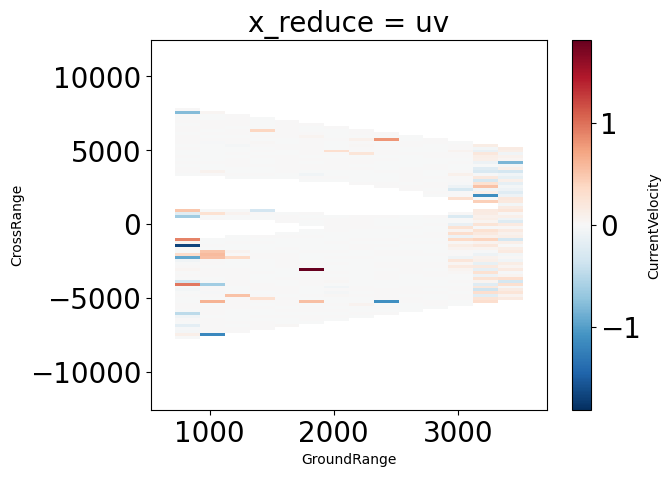

In [11]:
(ds_L2[track].CurrentVelocity - ds_L2_noisy[track].CurrentVelocity).plot()

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


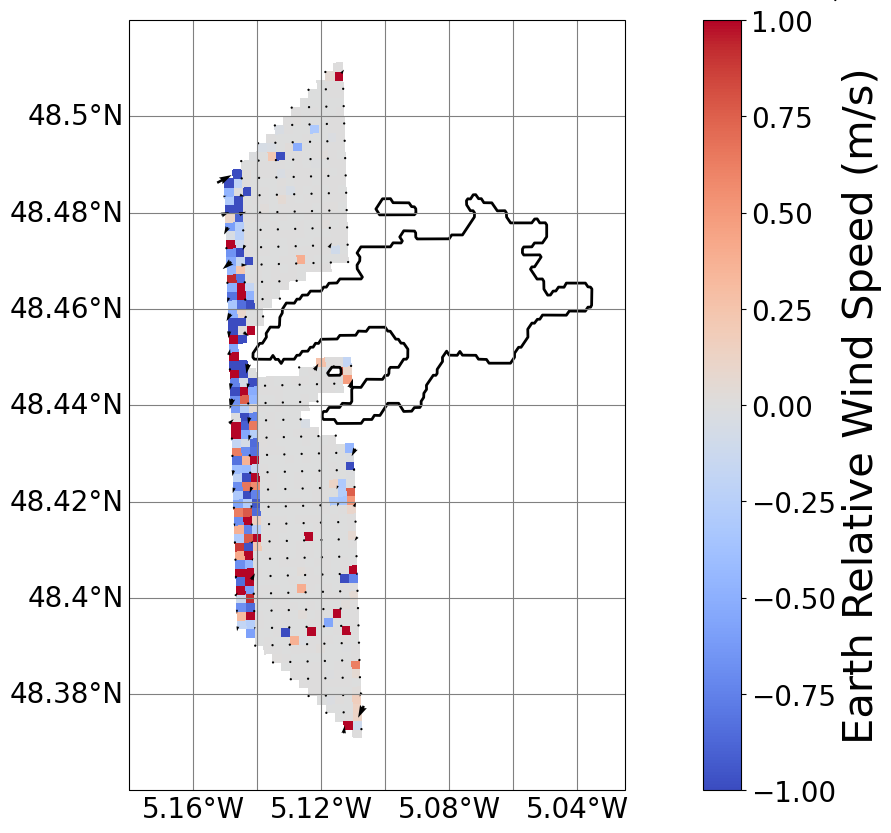

In [19]:
#------------------------------
var = 1
case = 'Oessant'
var_to_plot = {1:'EarthRelativeWindSpeed',2:'CurrentVelocity'}[var]
extent = {'Oessant':{'Track_1':[-5.18, -5.025, 48.425, 48.55],
                    'Track_2':[-5.18, -5.025, 48.36, 48.52]},
          'StarPattern':[-5.35, -5.15, 48.19, 48.31],
         'Ocean':[-5.2, -4.8, 46, 47.6]}[case]
#------------------------------
fig_size = (20, 10)
combined_tracks = False
save_figure = True
coarsening = False
vectors = True
plot_title = False
colorbar = True
grid = True
transparent = False

plot_pixel_size = 200 # desired plot pixel size in metres
sar_pixel_size = 8 # SAR pixel size in metres
c_factor_image = int(plot_pixel_size / sar_pixel_size) # coarsening factor for plotting
if var_to_plot=='CurrentVelocity':
    vmin=-1
    vmax = 1
    if level=='L1c':
        q_factor=40
        q_scale = 30
    else:
        if resolution=='100x100m':
            q_factor = 4 # Quiver plot posting factor
            q_scale = 40
        elif resolution=='200x200m':
            q_factor = 2 # Quiver plot posting factor
            q_scale = 40
elif var_to_plot in ['EarthRelativeWindSpeed','OceanSurfaceWindSpeed']:
    vmin= -1
    vmax = 1
    q_factor = 2 # Quiver plot posting factor
    q_scale = 180 # Quiver plot scaling factor

for track in ds_L2.keys():
    tracktime = str(np.datetime64(ds_L1c[track].sel(Antenna='Mid').TrackTime.data,'m'))
    if not combined_tracks:
        fig = plt.figure(figsize=fig_size)
        ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator(), frameon=True)
    if coarsening:
        im=ds_L2[track]\
        .coarsen(GroundRange=c_factor_image,boundary='trim').mean()\
        .coarsen(CrossRange=c_factor_image,boundary='trim').mean()\
        [var_to_plot]\
        .plot(
            y='latitude',x='longitude',
            robust=True, 
            cmap='coolwarm',vmin=0, vmax=vmax,
            transform=ccrs.PlateCarree(),
            add_colorbar=False,
        )
    else:
        im=(ds_L2[track][var_to_plot] - ds_L2_noisy[track][var_to_plot])\
        .plot(
            y='latitude',x='longitude',
            robust=True, 
            cmap='coolwarm',vmin=vmin, vmax=vmax,
            transform=ccrs.PlateCarree(),
            add_colorbar=False,
        )
    if vectors:
        (ds_L2[track]\
        .coarsen(GroundRange=q_factor,boundary='trim').mean()\
        .coarsen(CrossRange=q_factor,boundary='trim').mean() - 
         ds_L2_noisy[track]\
        .coarsen(GroundRange=q_factor,boundary='trim').mean()\
        .coarsen(CrossRange=q_factor,boundary='trim').mean())\
        .plot.quiver(
            x='longitude',y='latitude',
            u=var_to_plot.replace('Velocity','U').replace('Speed','U'),
            v=var_to_plot.replace('Velocity','V').replace('Speed','V'),
            scale=q_scale,width=0.005,
            robust=True,
            transform=ccrs.PlateCarree()
        )
    if grid:
        gl=ax.gridlines(draw_labels=True, color='gray')
        gl.top_labels=False
        gl.right_labels=False
    if transparent:
        ax.axis('off')
    ax.set_extent(extent[track],
                  crs=ccrs.PlateCarree())
#     ax.set_extent([-5.4, -5.1, 48.15, 48.35], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
    if colorbar:
        cbar = plt.colorbar(im)
        cbar.set_label([re.sub(r"(\w)([A-Z])", r"\1 \2", ele) for ele in [var_to_plot]][0] + ' (m/s)',fontsize=30)
    #plt.plot(-5.13305, 48.4166, marker="^", color='r', markersize=15, transform=ccrs.PlateCarree())
    filetime = tracktime.replace('-','')
    filetime = filetime.replace(':','')
    if level=='L2':
        save_name =\
            'OSCAR_'+ [re.sub(r"(\w)([A-Z])", r"\1_\2", ele) for ele in [var_to_plot]][0] + '_'\
            + 'simultaneous_' + resolution + '_' + gmf + '_' + filetime + '_XBandComparisonPlot'
    elif level=='L1c':
        save_name =\
            'OSCAR_'+ [re.sub(r"(\w)([A-Z])", r"\1_\2", ele) for ele in [var_to_plot]][0] + '_'\
            + 'sequential_' + resolution + '_' + gmf + '_' + filetime
    if plot_title:
        plt.title('OSCAR retrieved '+ [re.sub(r"(\w)([A-Z])", r"\1 \2", ele) for ele in [var_to_plot]][0] + '\n'
              + tracktime + '\n')
    else:
        plt.title('')
    if save_figure:
        fig_folder = os.path.join(fig_path, 'L2','')
        if transparent:
            plt.savefig(fig_folder + save_name + '_transparent.png', dpi=150, bbox_inches='tight', transparent=True)
        else:
            plt.savefig(fig_folder + save_name + '.png', dpi=150, bbox_inches='tight')
    if not combined_tracks:
        plt.show()
#plt.savefig(fig_folder + 'RSC_magnitude.png', dpi=150)
#ax.set_xlabel('Latitude', fontsize=14)

# Plot AROME winds

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


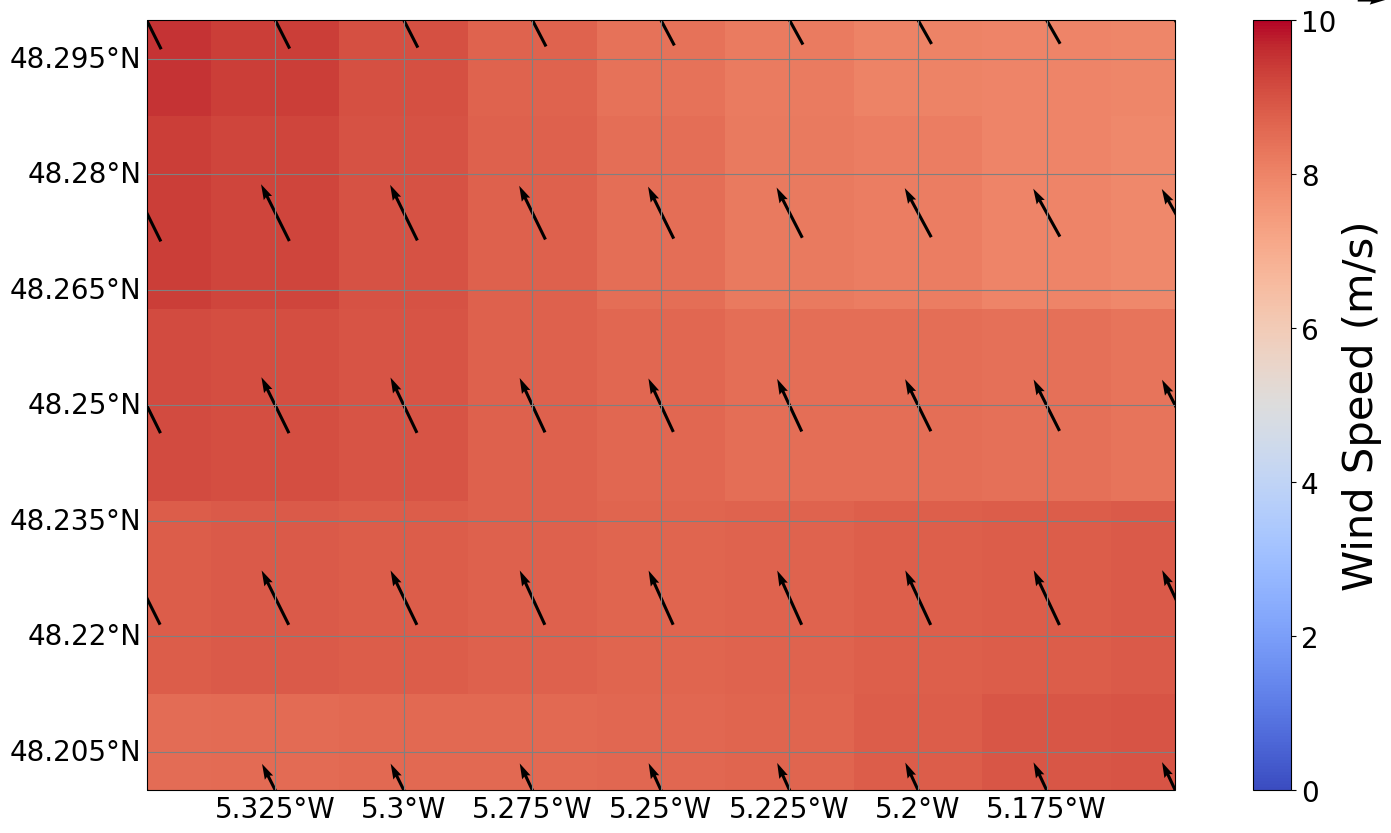

In [6]:


save_figure = False
case = 'StarPattern'
extent = {'Oessant':[-5.17, -5.025, 48.36, 48.52],
          'StarPattern':[-5.35, -5.15, 48.2, 48.3]}[case]
track_outline = True
plot_title = False

AROME_winds_sel = AROME_winds.sel(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest').isel(height=0)
windspeed, winddirection =\
ss.utils.tools.windUV2SpeedDir(AROME_winds_sel.u10m,
                               AROME_winds_sel.v10m)
AROME_winds_sel['WindSpeed'] = windspeed
AROME_winds_sel['WindDirection'] = xr.DataArray(data=winddirection,coords=windspeed.coords,dims=windspeed.dims)

q_factor=1
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator(), frameon=True)
im=AROME_winds_sel['WindSpeed']\
.plot(
    y='latitude',x='longitude',
    robust=True, 
    cmap='coolwarm',vmin=0, vmax=10,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
AROME_winds_sel\
        .coarsen(longitude=q_factor,boundary='trim').mean()\
        .coarsen(latitude=q_factor,boundary='trim').mean()\
        .plot.quiver(
            x='longitude',y='latitude',
            u='u10m',
            v='v10m',
            scale=150,width=0.003,
            robust=True,
            transform=ccrs.PlateCarree()
        )
gl=ax.gridlines(draw_labels=True, color='gray')
gl.top_labels=False
gl.right_labels=False
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
cbar = plt.colorbar(im)
cbar.set_label('Wind Speed (m/s)',fontsize=30)

AROME_time =\
str(np.datetime64(AROME_winds.sel(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest').time.data,'m'))
if plot_title:
    plt.title('AROME predicted U10 wind speed\n'+ AROME_time +'\n')
else:
    plt.title('')
if track_outline:
    a = [xr.where(np.isnan(ds_L1c[track].sel(Antenna=a).Sigma0),0,1) for a in ds_L1c[track].Antenna.data]
    beam_mask = xr.where((a[0] + a[1] + a[2])==3, 1, 0)
    outline_lat, outline_lon = find_mask_outline(beam_mask)
    plt.plot(outline_lon, outline_lat,'w',linewidth=2,transform=ccrs.PlateCarree())
if save_figure:
    save_name = 'AROME_Wind_Speed_' + AROME_time.replace('-','').replace(':','')
    fig_folder = os.path.join(fig_path, 'auxiliary','')
    plt.savefig(fig_folder + save_name + '.png', dpi=150, bbox_inches='tight')
plt.show()

# Load in Aux data

In [6]:
# track='Track_2'
# track='Track_11'
folder = 'unrestricted\\'
aux_file_list = os.listdir(file_paths['aux_path'] + folder)
MARS2D_files = [filename for filename in aux_file_list if 'MARS2D' in filename]
aux_list=dict()
if flight == '20220517':
    xband_path = 'D:\\data\\SEASTAR\\SEASTARex\\Data\\Hereon\\surface_currents\\'
    aux_list['Xband'] = xr.open_dataset(xband_path+'20220517T093043.nc')
    aux_list['Xband'] = aux_list['Xband'].assign_coords({'longitude':aux_list['Xband'].longitude,
                                'latitude':aux_list['Xband'].latitude})
    cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['Xband'].U_East.data,
                                    aux_list['Xband'].U_North.data)
    aux_list['Xband']['CurrentVelocity'] = (('y','x'), cvel)
    aux_list['Xband']['CurrentDirection'] = (('y','x'), cdir)
for data_type in ['MARS2D', 'MARS3D','HF_combined', 'WW3']:
    if bool(''.join([f for f in aux_file_list if data_type in f and flight in f])):
        aux_list[data_type] =xr.open_dataset(
            file_paths['aux_path'] + folder
            + ''.join([f for f in aux_file_list if data_type in f and flight in f])
                                            )
if 'MARS2D' in aux_list.keys():
    cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['MARS2D'].U.data, aux_list['MARS2D'].V.data)
    aux_list['MARS2D']['CurrentVelocity'] = (('time','nj','ni'), cvel)
    aux_list['MARS2D']['CurrentDirection'] = (('time','nj','ni'), cdir)
    timesel = np.argmin(np.abs(aux_list['MARS2D'].time.data - ds_L1c[track].sel(Antenna='Mid').TrackTime.data))
if 'HF_combined' in aux_list.keys():
    aux_list['HF_combined'] = aux_list['HF_combined'].assign_coords(
            coords={'longitude': aux_list['HF_combined'].longitude, 'latitude': aux_list['HF_combined'].latitude})
    cvel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['HF_combined'].U.data, aux_list['HF_combined'].V.data)
    aux_list['HF_combined']['CurrentVelocity'] = (('time','lat','lon'), cvel)
    aux_list['HF_combined']['CurrentDirection'] = (('time','lat','lon'), cdir)
    aux_list['HF_combined']['CurrentVelocity'].assign_coords({'latitude':aux_list['HF_combined'].latitude,
                                                         'longitude':aux_list['HF_combined'].longitude})

# aux_list['HF_radial'] = xr.open_dataset(file_paths['aux_path'] + folder
#                             + 'HF_Brezellec_Radial_2022.nc')
# aux_list['HF_radial'] = aux_list['HF_radial'].assign_coords({"latitude":(['lon', 'lat'], aux_list['HF_combined'].latitude.data),
#                                      "longitude":(['lon', 'lat'], aux_list['HF_combined'].longitude.data)})
# aux_list['HF_radial'] = aux_list['HF_radial'].drop_duplicates('time', keep='first')
aux_list['Trefle_MLM'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_MLM.nc')
aux_list['Trefle_MEM'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_MEM.nc')
aux_list['Trefle_spectra'] = xr.open_dataset(file_paths['aux_path'] + folder + 'Trefle_spectra.nc')
aux_list['Trefle'] = xr.open_dataset(file_paths['aux_path'] + folder + 'TREFLE_WH300_avg.nc')
aux_list['Trefle'] = aux_list['Trefle'].assign_coords(depth=("bin", aux_list['Trefle'].depth.data))

U_adcp = np.empty(0)
V_adcp = np.empty(0)
vel_adcp = np.empty(0)
dir_adcp = np.empty(0)

# for i in range(11,18 + 1):
for track in ds_L1c.keys():
    t = ds_L1c[track].TrackTime.sel(Antenna='Mid')
    u = aux_list['Trefle'].v_e.sel(time=t, method='nearest').isel(bin=0)\
        - aux_list['Trefle'].velocity_e.sel(time=t, method='nearest')
    v = aux_list['Trefle'].v_n.sel(time=t, method='nearest').isel(bin=0)\
        - aux_list['Trefle'].velocity_n.sel(time=t, method='nearest')
    vel, cdir = ss.utils.tools.currentUV2VelDir(aux_list['Trefle'].v_e.sel(time=t, method='nearest').isel(bin=0),
                                 aux_list['Trefle'].v_n.sel(time=t, method='nearest').isel(bin=0))
    U_adcp = np.append(U_adcp, u)
    V_adcp = np.append(V_adcp,v)
    vel_adcp = np.append(vel_adcp, vel)
    dir_adcp = np.append(dir_adcp, cdir)
    


print('...Done')


...Done


In [22]:
1/500

0.002

In [18]:
2.253e-03

0.002253

In [17]:
aux_list['MARS2D']

<xarray.Dataset>
Dimensions:           (ni: 584, nj: 754, ni_u: 584, nj_u: 754, ni_v: 584,
                       nj_v: 754, ni_f: 584, nj_f: 754, time: 16, level: 1)
Coordinates: (12/16)
  * ni                (ni) float32 1.0 2.0 3.0 4.0 ... 581.0 582.0 583.0 584.0
  * nj                (nj) float32 1.0 2.0 3.0 4.0 ... 751.0 752.0 753.0 754.0
  * ni_u              (ni_u) float32 1.5 2.5 3.5 4.5 ... 581.5 582.5 583.5 584.5
  * nj_u              (nj_u) float32 1.0 2.0 3.0 4.0 ... 751.0 752.0 753.0 754.0
  * ni_v              (ni_v) float32 1.0 2.0 3.0 4.0 ... 581.0 582.0 583.0 584.0
  * nj_v              (nj_v) float32 1.5 2.5 3.5 4.5 ... 751.5 752.5 753.5 754.5
    ...                ...
  * time              (time) datetime64[ns] 2022-05-17T06:00:00 ... 2022-05-1...
  * level             (level) float32 -0.5
    longitude_u       (nj_u, ni_u) float32 ...
    longitude_v       (nj_v, ni_v) float32 ...
    latitude_u        (nj_u, ni_u) float32 ...
    latitude_v        (nj_v, ni_v) float32 ...
Data variables:
    SIG               (level) float32 ...
    H0                (nj, ni) float32 ...
    HX                (nj_u, ni_u) float32 ...
    HY                (nj_v, ni_v) float32 ...
    XE                (time, nj, ni) float32 ...
    U                 (time, nj_u, ni_u) float32 nan nan nan ... -0.8069 0.0
    V                 (time, nj_v, ni_v) float32 nan 0.0 -0.5634 ... -0.1221 0.0
    DELTA_XE          (time, nj, ni) float32 ...
    DELTA_U           (time, nj_u, ni_u) float32 ...
    DELTA_V           (time, nj_v, ni_v) float32 ...
    CurrentVelocity   (time, nj, ni) float32 nan nan nan ... 0.8162 0.8161 0.0
    CurrentDirection  (time, nj, ni) float32 nan nan nan ... 261.4 261.4 90.0
Attributes: (12/55)
    limi:                    0
    lima:                    583
    pasi:                    1
    ljmi:                    0
    ljma:                    10
    pasj:                    1
    ...                      ...
    product_name:            MARC_L1-MARS2D-FINIS250_20220517T0600Z_MeteoMF.nc
    comment:                 Use of Meteo-France AROME & ARPEGE meteorologica...
    area:                    Iroise Sea
    start_date:              2022-05-17T06:00:00Z
    stop_date:               2022-05-17T06:00:00Z
    field_type:              0.25-hourly

# Colocate OSCAR data to X-Band coordinates

In [7]:
aux_list['Xband_colocated'] = xr.Dataset()
aux_list['Xband_colocated']['CurrentU'] = ss.retrieval.auxiliary.colocate_variable_lat_lon(
data_in=aux_list['Xband'].U_East,
latitude=aux_list['Xband'].latitude,
longitude=aux_list['Xband'].longitude,
ds_out=ds_L2[track].CurrentU)
aux_list['Xband_colocated']['CurrentV'] = ss.retrieval.auxiliary.colocate_variable_lat_lon(
data_in=aux_list['Xband'].U_North,
latitude=aux_list['Xband'].latitude,
longitude=aux_list['Xband'].longitude,
ds_out=ds_L2[track].CurrentV)

# Plot X-band

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


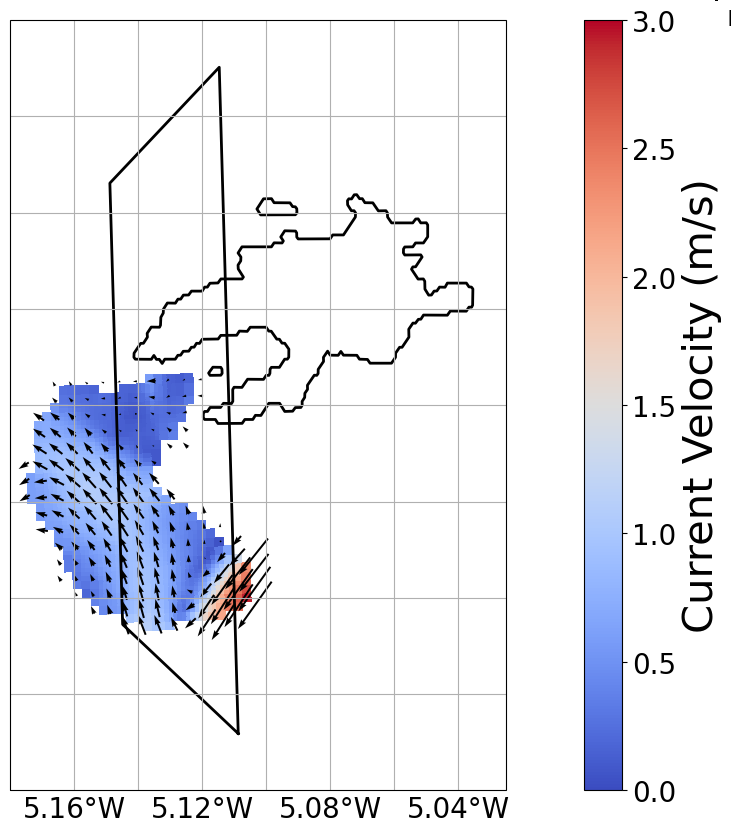

In [13]:
save_figure = True
plot_title = False
colorbar = True

extent = [-5.18, -5.025, 48.36, 48.52]
# extent=[-5.17, -5.025, 48.36, 48.52]
q_factor=50
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im=aux_list['Xband'].CurrentVelocity\
.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=3,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
aux_list['Xband']\
.coarsen(x=q_factor,boundary='trim').mean().coarsen(y=q_factor,boundary='trim').mean()\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='U_East',
    v='U_North',
    scale=25,width=0.004,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
gl=ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False
gl.left_labels=False
if colorbar:
    cbar = plt.colorbar(im,ax=ax)
    cbar.set_label('Current Velocity (m/s)',fontsize=30)
save_name ='X-band_CurrentVelocity_'+aux_list['Xband'].start_time
#plt.savefig(fig_folder + save_name + '.png', dpi=150, bbox_inches='tight')
if plot_title:
    plt.title('X-band derived surface current velocity\n' +aux_list['Xband'].start_time+'\n')
else:
    plt.title('')

a = [xr.where(np.isnan(ds_L1c[track].sel(Antenna=a).Sigma0),0,1) for a in ds_L1c[track].Antenna.data]
beam_mask = xr.where((a[0] + a[1] + a[2])==3, 1, 0)
outline_lat, outline_lon = find_mask_outline(beam_mask)

plt.plot(outline_lon, outline_lat,'k',linewidth=2,transform=ccrs.PlateCarree())
if save_figure:
        save_name = 'X-band_Current_Velocity_OscarComparisonPlot_' + aux_list['Xband'].start_time
        fig_folder = os.path.join(fig_path, 'auxiliary','')
        plt.savefig(fig_folder + save_name + '.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot OSCAR and X-band vectors

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


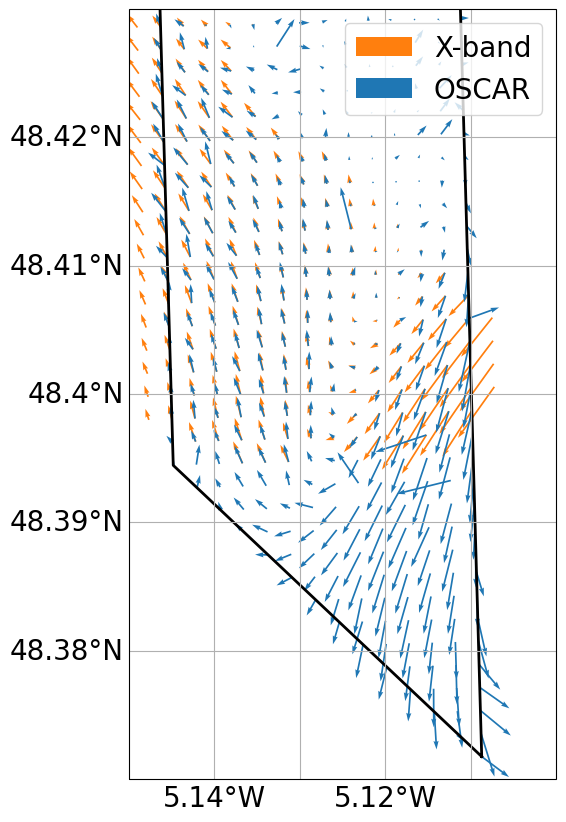

In [38]:
q_factor=1
q_scale=20
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
aux_list['Xband_colocated']\
.coarsen(CrossRange=q_factor,boundary='trim').mean().coarsen(GroundRange=q_factor,boundary='trim').mean()\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='CurrentU',
    v='CurrentV',
    scale=q_scale,width=0.004,
    angles='xy',
    pivot='tail',
    robust=True,
    transform=ccrs.PlateCarree(),
    color='C1',
    label='X-band'
)
q_factor=1
var_to_plot='CurrentVelocity'
ds_L2[track]\
        .coarsen(GroundRange=q_factor,boundary='trim').mean()\
        .coarsen(CrossRange=q_factor,boundary='trim').mean()\
        .plot.quiver(
            x='longitude',y='latitude',
            u=var_to_plot.replace('Velocity','U').replace('Speed','U'),
            v=var_to_plot.replace('Velocity','V').replace('Speed','V'),
            scale=q_scale,width=0.004,
            angles='xy',
            pivot='tail',
            robust=True,
            transform=ccrs.PlateCarree(),color='C0',
            label='OSCAR'
        )

ax.set_extent([-5.15, -5.1, 48.37, 48.43], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
gl=ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False
# cbar = plt.colorbar(im,ax=ax)
# cbar.set_label('Current Velocity (m/s)',fontsize=30)
save_name ='X-band_CurrentVelocity_'+aux_list['Xband'].start_time
plt.legend()
# plt.title('X-band and OSCAR current vector comparison')
plt.title('')
#plt.savefig(fig_folder + save_name + '.png', dpi=150, bbox_inches='tight')


a = [xr.where(np.isnan(ds_L1c[track].sel(Antenna=a).Sigma0),0,1) for a in ds_L1c[track].Antenna.data]
beam_mask = xr.where((a[0] + a[1] + a[2])==3, 1, 0)
outline_lat, outline_lon = find_mask_outline(beam_mask)

plt.plot(outline_lon, outline_lat,'k',linewidth=2,transform=ccrs.PlateCarree())
plt.show()

In [311]:
Uerr= np.sqrt(np.nanmean((aux_list['Xband_colocated'].CurrentU - ds_L2[track].CurrentU) **2) )
Verr= np.sqrt(np.nanmean((aux_list['Xband_colocated'].CurrentV - ds_L2[track].CurrentV) **2) )
print('RMSE U = ',str(round(Uerr,2)))
print('RMSE V = ',str(round(Verr,2)))

RMSE U =  0.34
RMSE V =  0.25


In [10]:
Uerr= np.sqrt(np.nanmean((aux_list['Xband_colocated'].CurrentU - ds_L2[track].CurrentU) **2) )
Verr= np.sqrt(np.nanmean((aux_list['Xband_colocated'].CurrentV - ds_L2[track].CurrentV) **2) )
print('RMSE U = ',str(round(Uerr,2)))
print('RMSE V = ',str(round(Verr,2)))

RMSE U =  0.39
RMSE V =  0.23


# Plot OSCAR / Xband U/V comparison

In [16]:
'X-band_OSCAR_U_V_comparison_'+ gmf + '_' + aux_list['Xband'].start_time

'X-band_OSCAR_U_V_comparison_mouche12_20220517T093545'

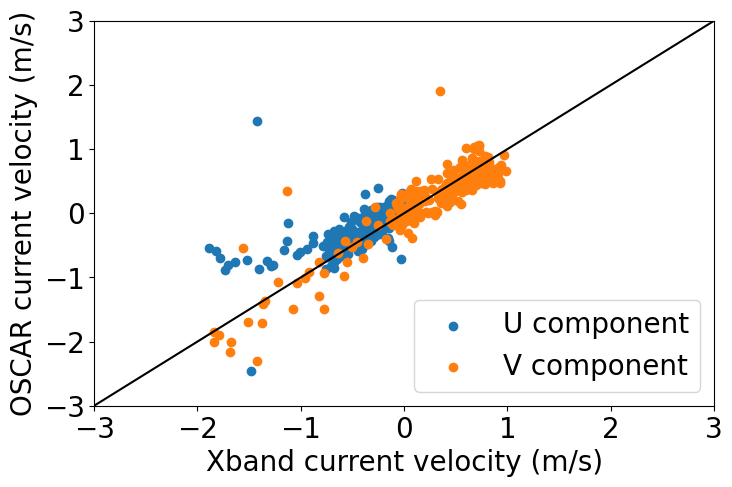

In [28]:
save_figure = False
fig = plt.figure(figsize=(8,5))
plt.scatter(np.ravel(aux_list['Xband_colocated'].CurrentU),
        np.ravel(ds_L2[track].CurrentU),
            label='U component'
        )
plt.scatter(np.ravel(aux_list['Xband_colocated'].CurrentV),
        np.ravel(ds_L2[track].CurrentV),
            label='V component'
        )
plt.legend()
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.plot([-3,3],[-3,3],'k')
plt.xlabel('Xband current velocity (m/s)', fontsize=20)
plt.ylabel('OSCAR current velocity (m/s)', fontsize=20)
plt.title('')
if save_figure:
        save_name = 'X-band_OSCAR_U_V_comparison_'+ gmf + '_' + aux_list['Xband'].start_time
        fig_folder = os.path.join(fig_path, 'comparisons','')
        plt.savefig(fig_folder + save_name + '.png', dpi=150, bbox_inches='tight')
plt.show()

# MARS2D

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


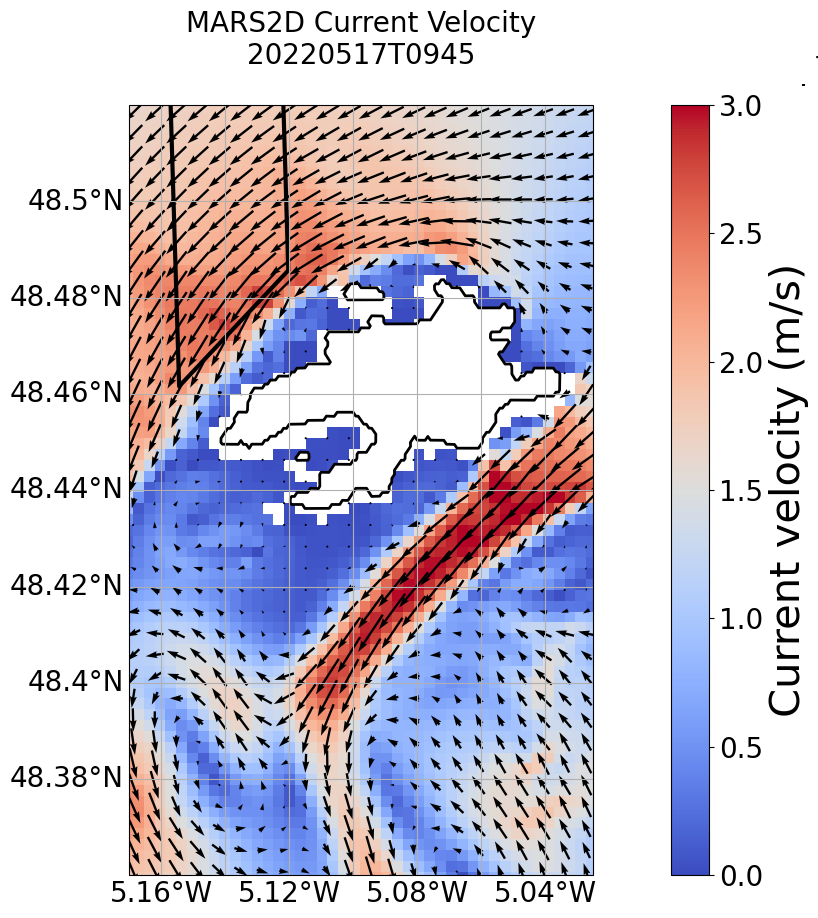

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


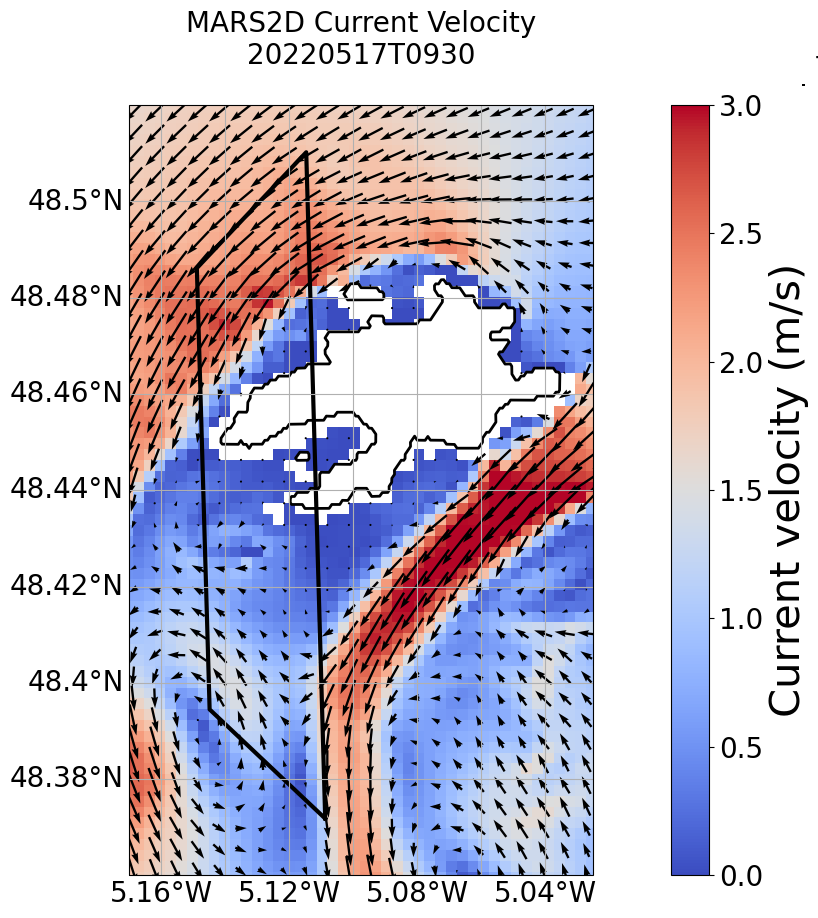

In [11]:
case = 'Oessant'
extent = {'Oessant':[-5.17, -5.025, 48.36, 48.52],
          'StarPattern':[-5.35, -5.15, 48.2, 48.3]}[case]
save_figure = False
outline = True
plot_title = True
colorbar = True

if case == 'StarPattern':
    tracks = ['Track_11']
else:
    tracks = ds_L2.keys()
for track in tracks:
    timesel = np.argmin(np.abs(aux_list['MARS2D'].time.data - ds_L1c[track].sel(Antenna='Mid').TrackTime.data))
    plot_pixel_size = 200 #pixel size in metres
    sar_pixel_size = 8
    c_factor = int(plot_pixel_size / sar_pixel_size)
    q_factor = 2 # Quiver plot scaling factor
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
    im = aux_list['MARS2D'].CurrentVelocity\
    .isel(time=timesel)\
    .plot(
        y='latitude',
        x='longitude',
        robust=True, 
        cmap='coolwarm',
        vmin=0, vmax=3,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
    aux_list['MARS2D']['U_coloc'], aux_list['MARS2D']['V_coloc'] =\
        ss.utils.tools.currentVelDir2UV(aux_list['MARS2D'].CurrentVelocity,
                                        aux_list['MARS2D'].CurrentDirection)
    aux_list['MARS2D']\
    .isel(time=timesel)\
    .coarsen(nj=q_factor,boundary='trim').mean().coarsen(ni=q_factor,boundary='trim').mean()\
    .plot.quiver(
        x='longitude',
        y='latitude',
        u='U_coloc',
        v='V_coloc',
        scale=30, width=0.005,
        angles='xy',
        robust=True,
        transform=ccrs.PlateCarree()
    )
    #plt.title('MARS2D')
    gl=ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False
    
#     gl.left_labels=False
    
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
    if colorbar:
        cbar = plt.colorbar(im,ax=ax)
        cbar.set_label('Current velocity (m/s)',fontsize=30)
    tracktime = str(np.datetime64(aux_list['MARS2D'].time.isel(time=timesel).data,'m'))
    filetime = tracktime.replace('-','')
    filetime = filetime.replace(':','')
    save_name ='MARS2D_CurrentVelocity_'+'_'+filetime
    if plot_title:
        plt.title('MARS2D Current Velocity\n' + filetime +'\n')
    else:
        plt.title('')
    if outline:
        a = [xr.where(np.isnan(ds_L1c[track].sel(Antenna=a).Sigma0),0,1) for a in ds_L1c[track].Antenna.data]
        beam_mask = xr.where((a[0] + a[1] + a[2])==3, 1, 0)
        outline_lat, outline_lon = find_mask_outline(beam_mask)
        plt.plot(outline_lon, outline_lat,'k',linewidth=3,transform=ccrs.PlateCarree())
    if save_figure:
        fig_folder = os.path.join(fig_path, 'auxiliary','')
        plt.savefig(fig_folder + save_name + '.png', dpi=150, bbox_inches='tight')
    
    plt.show()

# Colocate MARS2D with OSCAR

In [7]:
aux_list['MARS2D_colocated'] = xr.Dataset()
# lat, lon = np.meshgrid()
aux_list['MARS2D_colocated']['CurrentU'] = ss.retrieval.auxiliary.colocate_variable_lat_lon(
    data_in=aux_list['MARS2D'].isel(time=timesel).U,
    latitude=aux_list['MARS2D'].latitude_u,
    longitude=aux_list['MARS2D'].longitude_u,
    ds_out=ds_L2[track].CurrentU,
)
aux_list['MARS2D_colocated']['CurrentV'] = ss.retrieval.auxiliary.colocate_variable_lat_lon(
    data_in=aux_list['MARS2D'].isel(time=timesel).V,
    latitude=aux_list['MARS2D'].latitude_v,
    longitude=aux_list['MARS2D'].longitude_v,
    ds_out=ds_L2[track].CurrentV,
)

# Plot MARS2D / OSCAR U/V comparison

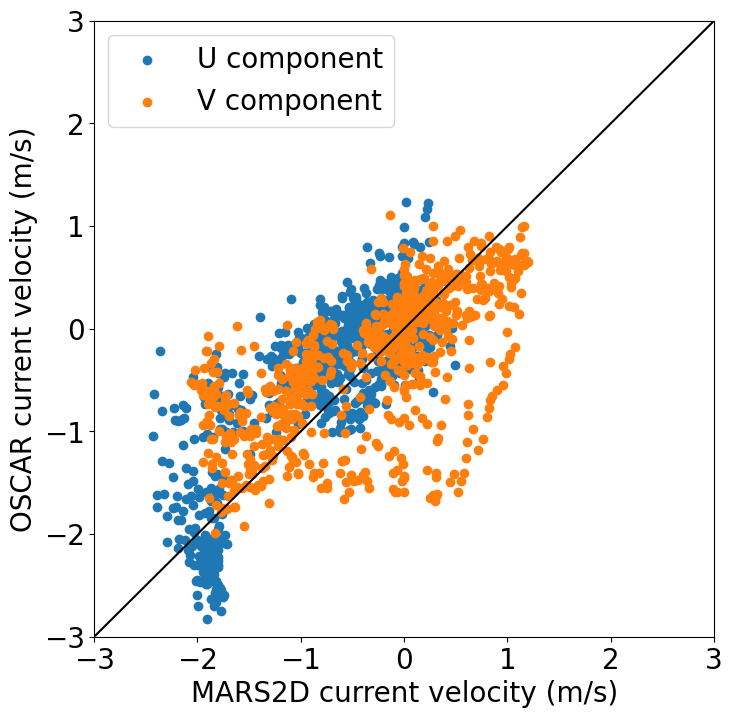

In [15]:

fig = plt.figure(figsize=(8, 8))
plt.scatter(np.ravel(aux_list['MARS2D_colocated'].CurrentU),
        np.ravel(ds_L2[track].CurrentU),
            label='U component'
        )
plt.scatter(np.ravel(aux_list['MARS2D_colocated'].CurrentV),
        np.ravel(ds_L2[track].CurrentV),
            label='V component'
        )
plt.legend()
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.plot([-3,3],[-3,3],'k')
plt.xlabel('MARS2D current velocity (m/s)', fontsize=20)
plt.ylabel('OSCAR current velocity (m/s)', fontsize=20)
plt.title('')
plt.show()

# HF Radar

# Plot current vector maps

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


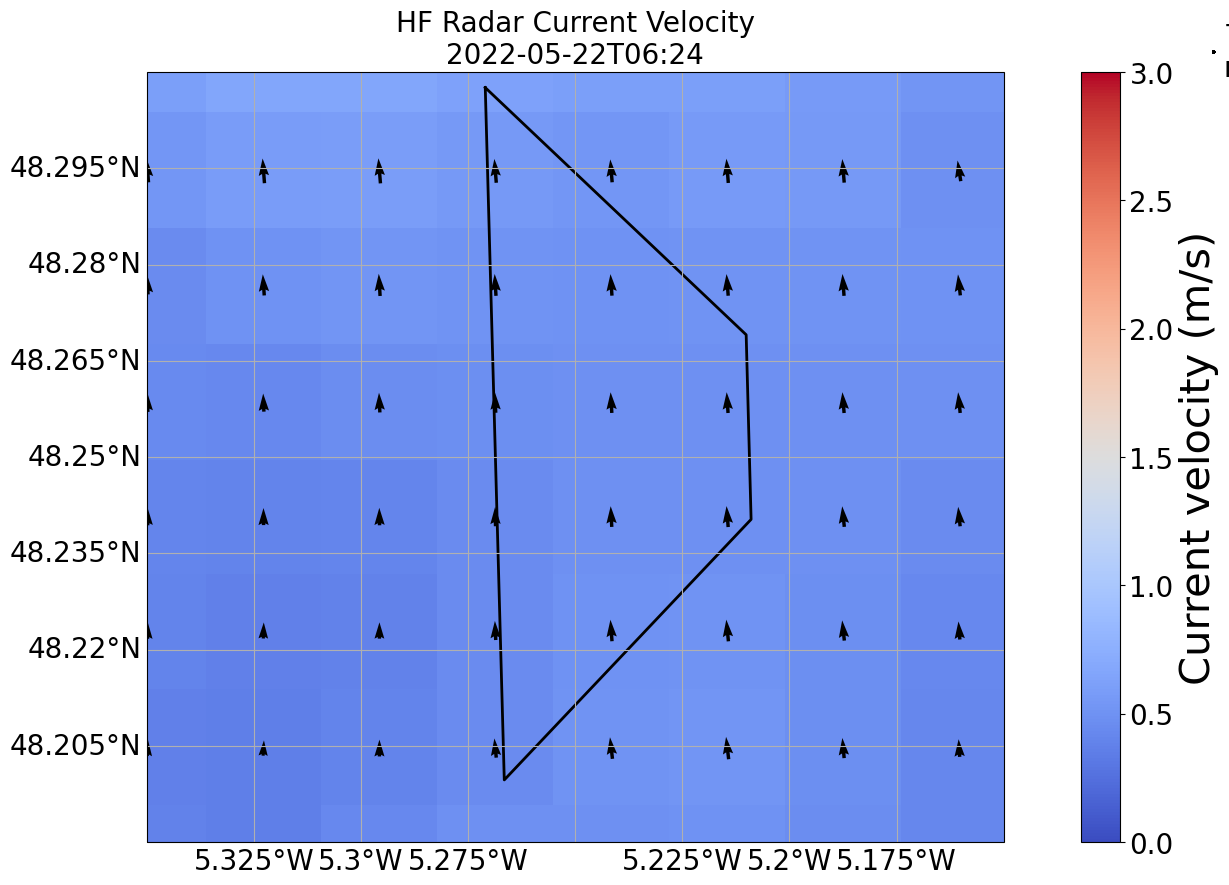

In [24]:
save_figure = False
case = 'StarPattern'
extent = {'Oessant':[-5.2, -5.025, 48.37, 48.55],
          'StarPattern':[-5.35, -5.15, 48.19, 48.31]}[case]
track_outline = False

for track in ['Track_11']:
# for track in ds_L2.keys():
    timesel = np.argmin(np.abs(aux_list['HF_combined'].time.data - ds_L1c[track].sel(Antenna='Mid').TrackTime.data))
    plot_pixel_size = 200 #pixel size in metres
    sar_pixel_size = 8
    c_factor = int(plot_pixel_size / sar_pixel_size)
    q_factor = 30 # Quiver plot scaling factor
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
    im = aux_list['HF_combined'].CurrentVelocity\
    .isel(time=timesel)\
    .plot(
        y='latitude',
        x='longitude',
        robust=True, 
        cmap='coolwarm',
        vmin=0, vmax=3,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
    )
#     aux_list['MARS2D']['U_coloc'], aux_list['MARS2D']['V_coloc'] =\
#         ss.utils.tools.currentVelDir2UV(aux_list['MARS2D'].CurrentVelocity,
#                                         aux_list['MARS2D'].CurrentDirection)
    aux_list['HF_combined']\
    .isel(time=timesel)\
    .plot.quiver(
        x='longitude',
        y='latitude',
        u='U',
        v='V',
        scale=20,width=0.004,
        angles='xy',
        pivot='mid',
        robust=True,
        transform=ccrs.PlateCarree()
    )
    #plt.title('MARS2D')
    gl=ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
    
    cbar = plt.colorbar(im,ax=ax)
    cbar.set_label('Current velocity (m/s)',fontsize=30)
    tracktime = str(np.datetime64(aux_list['HF_combined'].time.isel(time=timesel).data,'m'))
    filetime = tracktime.replace('-','')
    filetime = filetime.replace(':','')
    plt.title('HF Radar Current Velocity\n'+tracktime)
    save_name ='HF_Current_Velocity_'+'_'+filetime

    a = [xr.where(np.isnan(ds_L1c[track].sel(Antenna=a).Sigma0),0,1) for a in ds_L1c[track].Antenna.data]
    beam_mask = xr.where((a[0] + a[1] + a[2])==3, 1, 0)
    outline_lat, outline_lon = find_mask_outline(beam_mask)
    plt.plot(outline_lon, outline_lat,'k',linewidth=2,transform=ccrs.PlateCarree())
    fig_folder = os.path.join(fig_path, 'auxiliary','')
    if save_figure:
        plt.savefig(fig_folder + save_name + '.png', dpi=150, bbox_inches='tight')
    plt.show()

In [8]:
aux_list['HF_colocated'] = xr.Dataset()
# lat, lon = np.meshgrid()
aux_list['HF_colocated']['CurrentU'] = ss.retrieval.auxiliary.colocate_variable_lat_lon(
    data_in=aux_list['HF_combined'].isel(time=timesel).U,
    latitude=aux_list['HF_combined'].latitude,
    longitude=aux_list['HF_combined'].longitude,
    ds_out=ds_L2[track].CurrentU,
)
aux_list['HF_colocated']['CurrentV'] = ss.retrieval.auxiliary.colocate_variable_lat_lon(
    data_in=aux_list['HF_combined'].isel(time=timesel).V,
    latitude=aux_list['HF_combined'].latitude,
    longitude=aux_list['HF_combined'].longitude,
    ds_out=ds_L2[track].CurrentV,
)

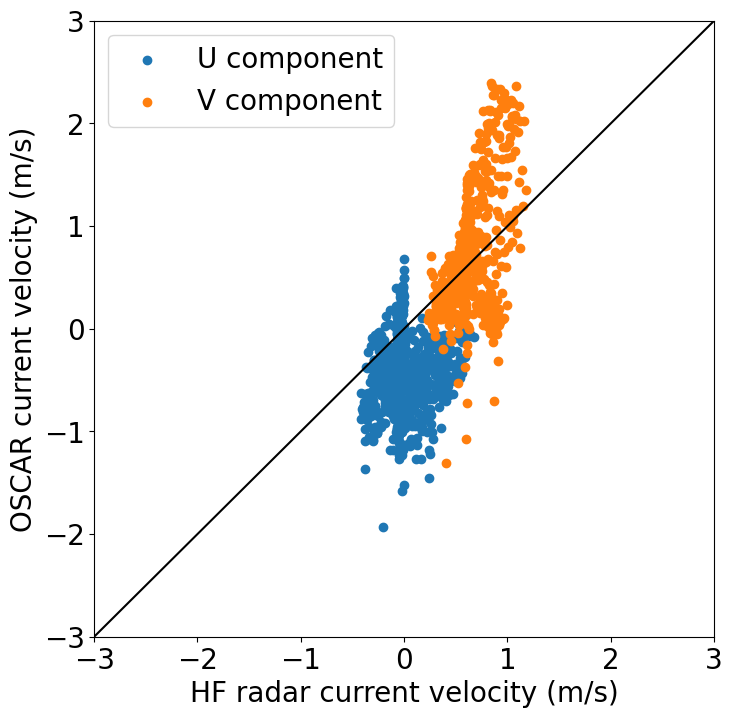

In [15]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(np.ravel(aux_list['HF_colocated'].CurrentU),
        np.ravel(ds_L2[track].CurrentU),
            label='U component'
        )
plt.scatter(np.ravel(aux_list['HF_colocated'].CurrentV),
        np.ravel(ds_L2[track].CurrentV),
            label='V component'
        )
plt.legend()
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.plot([-3,3],[-3,3],'k')
plt.xlabel('HF radar current velocity (m/s)', fontsize=20)
plt.ylabel('OSCAR current velocity (m/s)', fontsize=20)
plt.title('')
plt.show()

# ADCP data

In [15]:
aux_list['Trefle']

<xarray.Dataset>
Dimensions:     (time: 1524, bin: 100)
Coordinates:
  * time        (time) datetime64[ns] 2022-05-13T12:00:00 ... 2022-05-24T01:5...
    depth       (bin) float32 3.0 4.0 5.0 6.0 7.0 ... 99.0 100.0 101.0 102.0
Dimensions without coordinates: bin
Data variables:
    longitude   (time) float64 ...
    latitude    (time) float64 ...
    velocity_e  (time) float32 ...
    velocity_n  (time) float32 ...
    velocity_u  (time) float32 ...
    v_e         (time, bin) float32 ...
    v_n         (time, bin) float32 ...
    v_u         (time, bin) float32 ...
    RSSI        (time, bin) float32 ...
Attributes:
    Title:          SUMOS TREFLE Buoy RDI WH300 record
    Creation_date:  2022-06-04T11:41:53
    Contact:        L. MARIE : louis.marie@ifremer.fr
    Instrument:     TREFLE buoy RDI WorkHorse 300 kHz ADCP
    Manufacturer:   RDI
    Campaign:       SUMOS
    buoy_ID:        TREFLE 1

Text(0.5, 0, 'Velocity (m/s)')

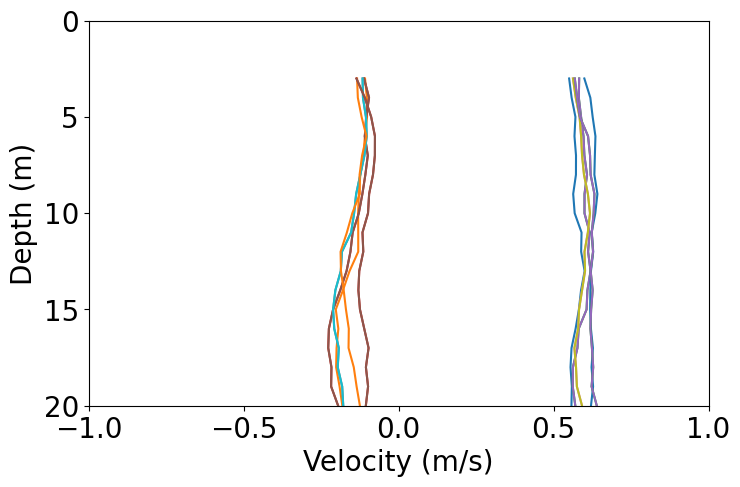

In [41]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,1,1) 

u = (aux_list['Trefle'].v_e - aux_list['Trefle'].velocity_e)
for track in ds_L1c.keys():
    t = aux_list['Trefle'].time.sel(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest').data
    plt.plot(v.sel(time=t, method='nearest'),aux_list['Trefle'].depth)
    plt.plot(u.sel(time=t, method='nearest'),aux_list['Trefle'].depth)
plt.xlim([-1,1])
plt.ylim([0,20])
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)', fontsize=20)
plt.xlabel('Velocity (m/s)', fontsize=20)

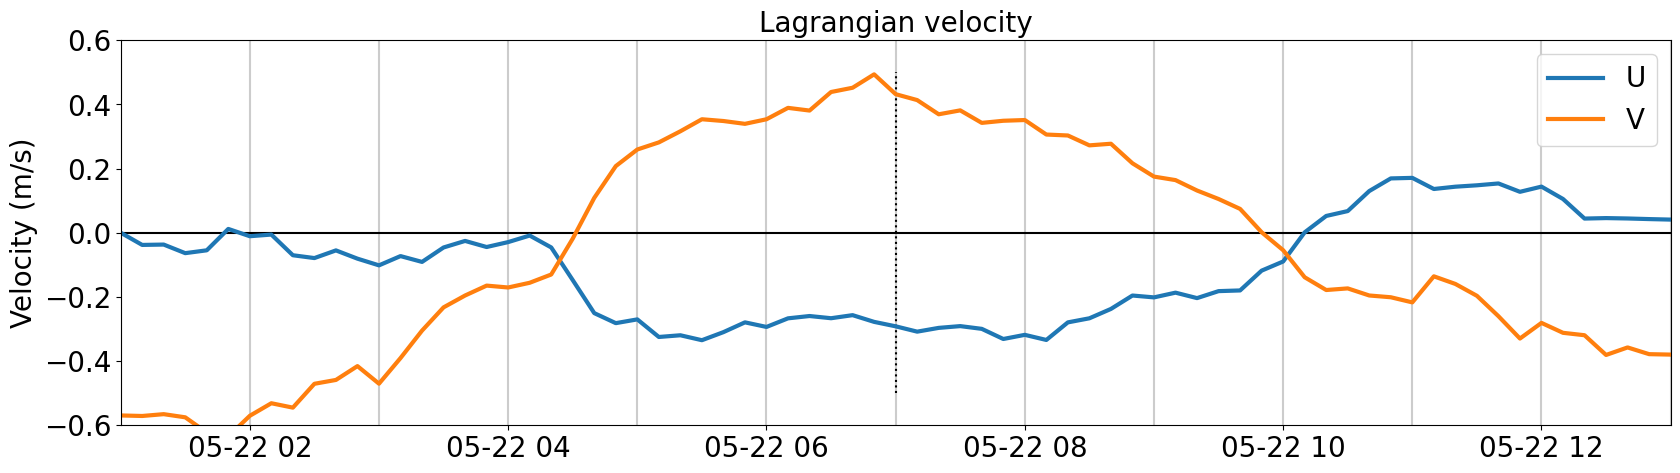

In [413]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1,1,1) 
t = aux_list['Trefle'].time.sel(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest').data


times = np.arange(t-np.timedelta64(1, 'D'), t+np.timedelta64(1, 'D'), np.timedelta64(1, 'h'))
for i in range(len(times)):
    plt.plot([times[i], times[i]],[-0.6,0.6],c=[0.8,0.8,0.8])
plt.plot([t,t],[-0.5,0.5],'k', linestyle=':')
plt.plot([t-np.timedelta64(6, 'h'), t+np.timedelta64(6, 'h')], [0,0],'k')
plt.plot(aux_list['Trefle'].time, aux_list['Trefle'].isel(bin=0).v_e, label='U', linewidth=3)
plt.plot(aux_list['Trefle'].time, aux_list['Trefle'].isel(bin=0).v_n, label='V', linewidth=3)
plt.title('Lagrangian velocity')

plt.xlim([t-np.timedelta64(6, 'h'), t+np.timedelta64(6, 'h')])
ax.set_ylim(-0.6,0.6)
plt.legend()
plt.ylabel('Velocity (m/s)', fontsize=20)
plt.show()

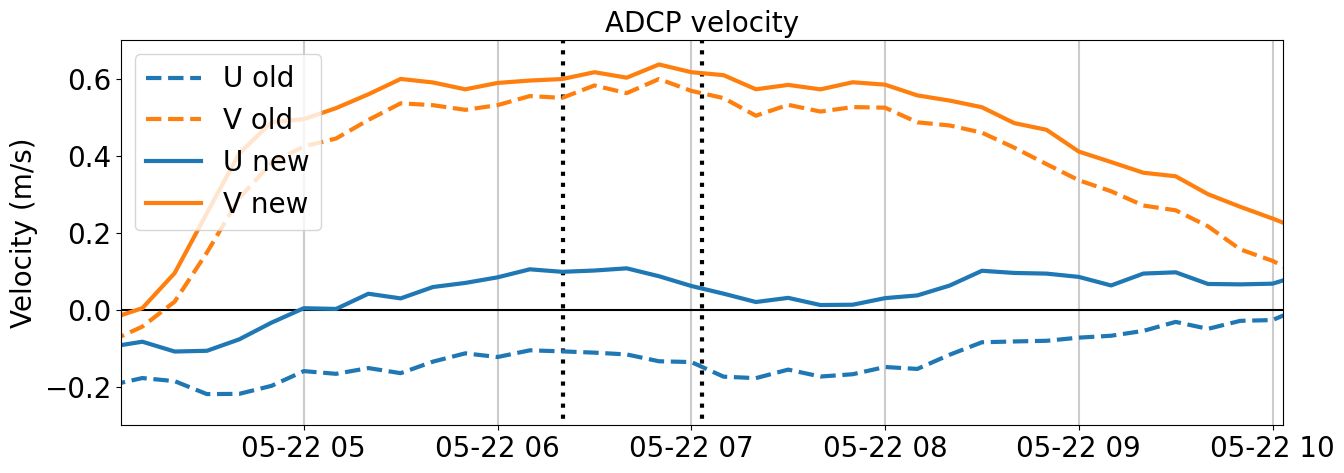

In [749]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1,1,1) 
t = aux_list['Trefle'].time.sel(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest').data


times = np.arange(t-np.timedelta64(1, 'D'), t+np.timedelta64(1, 'D'), np.timedelta64(1, 'h'))
for i in range(len(times)):
    plt.plot([times[i], times[i]],[-0.6,0.7],c=[0.8,0.8,0.8])
for track in ['Track_11', 'Track_18']:
    t = ds_L1c[track].sel(Antenna='Mid').TrackTime.data
    plt.plot([t,t],[-0.6,0.7],'k', linestyle=':', linewidth=3)
plt.plot([t-np.timedelta64(6, 'h'), t+np.timedelta64(6, 'h')], [0,0],'k')
plt.plot(aux_list['Trefle'].time, aux_list['Trefle'].isel(bin=0).v_e
         - aux_list['Trefle'].isel(bin=0).velocity_e, label='U old', linewidth=3,linestyle='dashed')
plt.plot(aux_list['Trefle'].time, aux_list['Trefle'].isel(bin=0).v_n
         - aux_list['Trefle'].isel(bin=0).velocity_n, label='V old', linewidth=3,linestyle='dashed')
plt.title('ADCP velocity')
ax.set_ylim(-0.3,0.7)
plt.xlim([t-np.timedelta64(3, 'h'), t+np.timedelta64(3, 'h')])
# plt.plot(aux_list['Trefle2'].time, aux_list['Trefle'].isel(bin=0).v_e
#          - aux_list['Trefle2'].isel(bin=0).velocity_e, label='U_2', linewidth=3)
# plt.plot(aux_list['Trefle2'].time, aux_list['Trefle'].isel(bin=0).v_n
#          - aux_list['Trefle2'].isel(bin=0).velocity_n, label='V_2', linewidth=3)
plt.plot(aux_list['Trefle2'].time, aux_list['Trefle2'].isel(bin=0).v_e, label='U new', linewidth=3,c='C0')
plt.plot(aux_list['Trefle2'].time, aux_list['Trefle2'].isel(bin=0).v_n, label='V new', linewidth=3,c='C1')
plt.legend()
plt.ylabel('Velocity (m/s)', fontsize=20)
plt.show()

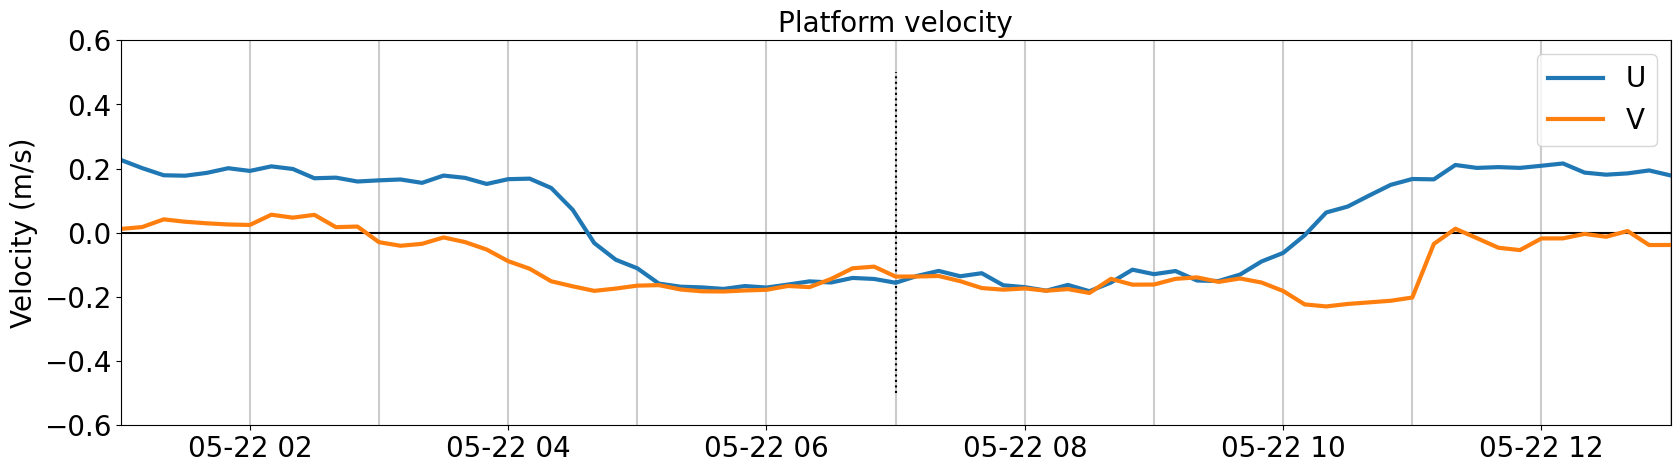

In [415]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1,1,1) 
t = aux_list['Trefle'].time.sel(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest').data


times = np.arange(t-np.timedelta64(1, 'D'), t+np.timedelta64(1, 'D'), np.timedelta64(1, 'h'))
for i in range(len(times)):
    plt.plot([times[i], times[i]],[-0.6,0.6],c=[0.8,0.8,0.8])
plt.plot([t,t],[-0.5,0.5],'k', linestyle=':')
plt.plot([t-np.timedelta64(6, 'h'), t+np.timedelta64(6, 'h')], [0,0],'k')
plt.plot(aux_list['Trefle'].time, aux_list['Trefle'].isel(bin=0).velocity_e, label='U', linewidth=3)
plt.plot(aux_list['Trefle'].time, aux_list['Trefle'].isel(bin=0).velocity_n, label='V', linewidth=3)
plt.title('Platform velocity')
ax.set_ylim(-0.6,0.6)
plt.xlim([t-np.timedelta64(6, 'h'), t+np.timedelta64(6, 'h')])
plt.legend()
plt.ylabel('Velocity (m/s)', fontsize=20)
plt.show()

# Checking true platform velocity from differential of position

In [585]:
easting = [np.NaN] * len(aux_list['Trefle'].longitude)
northing = [np.NaN] * len(aux_list['Trefle'].longitude)
zone_num = [np.NaN] * len(aux_list['Trefle'].longitude)
zone = [np.NaN] * len(aux_list['Trefle'].longitude)
for i in range(len(aux_list['Trefle'].longitude)):
    (easting[i], northing[i], zone_num[i], zone[i]) = utm.from_latlon(aux_list['Trefle'].latitude[i], aux_list['Trefle'].longitude[i])


C:\Users\davidmccann\AppData\Local\Temp\ipykernel_18200\3211815600.py:1: RuntimeWarning: invalid value encountered in true_divide
  platform_u = np.append([0],np.diff(easting)) / np.append([0],np.diff(aux_list['Trefle'].time) / np.timedelta64(1, 's'))
C:\Users\davidmccann\AppData\Local\Temp\ipykernel_18200\3211815600.py:2: RuntimeWarning: invalid value encountered in true_divide
  platform_v = np.append([0],np.diff(northing)) / np.append([0],np.diff(aux_list['Trefle'].time) / np.timedelta64(1, 's'))


(19134.16894675926, 19134.41894675926)

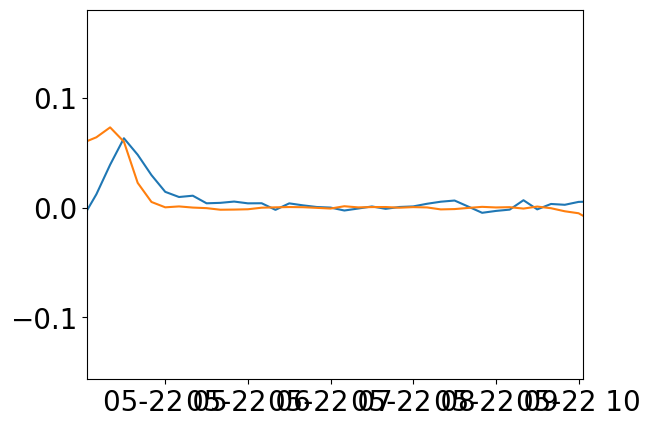

In [619]:
platform_u = np.append([0],np.diff(easting)) / np.append([0],np.diff(aux_list['Trefle'].time) / np.timedelta64(1, 's'))
platform_v = np.append([0],np.diff(northing)) / np.append([0],np.diff(aux_list['Trefle'].time) / np.timedelta64(1, 's'))

plt.plot(aux_list['Trefle'].time, platform_u)
plt.plot(aux_list['Trefle'].time, platform_v)
plt.xlim([t-np.timedelta64(3, 'h'), t+np.timedelta64(3, 'h')])

# Star Pattern mapping
    - Define a local grid
    - Create new dataset of relevant variables with only lat lon coordinates (no CrossRange, GroundRange)
    - Interp_like (or similar) onto the new grid


# OSCAR vs HF Current Velocity RMS error
Calculated by first degreading the OSCAR posting by 'degrade_res', interpolating the OSCAR data to the HF lat/lon
coordinates and then calculating the RMS error

In [561]:
degrade_res = 2000
c_factor = int(degrade_res/200)
da = ds_L2[track].CurrentVelocity.coarsen(CrossRange=10, GroundRange=10, boundary='trim').mean()

RMS((xr.concat([xr.DataArray(data=interpolate.griddata(points=(np.ravel(ds_L2[track]
                                                        .CurrentVelocity
                                                        .rolling(CrossRange=c_factor, GroundRange=c_factor)
                                                        .mean().latitude),
                                               np.ravel(ds_L2[track]
                                                        .CurrentVelocity
                                                        .rolling(CrossRange=c_factor, GroundRange=c_factor)
                                                        .mean().longitude)),
                                values=(np.ravel(ds_L2[track]
                                                 .CurrentVelocity
                                                 .rolling(CrossRange=c_factor, GroundRange=c_factor)
                                                 .mean())),
                            xi=(aux_list['HF_combined'].latitude,
                                aux_list['HF_combined'].longitude),
                            method='linear'),
             coords=aux_list['HF_combined'].CurrentVelocity.isel(time=0).coords,
             dims=aux_list['HF_combined'].CurrentVelocity.isel(time=0).dims
            ) for track in ds_L2.keys()],
          dim='Track') - xr.concat([
                            aux_list['HF_combined'].CurrentVelocity.sel(time=ds_L1c[track]
                                                                        .sel(Antenna='Mid')
                                                                        .TrackTime,
                                                                        method='nearest')
                            for track in ds_L1c.keys()],
                            dim='Track')).mean(dim=['lat','lon']))

<xarray.DataArray ()>
array(0.14513344)
Coordinates:
    Antenna  <U3 'Mid'

In [725]:
incidence_angle_min = 30
incidence_angle_max = 62
dsl2 = ds_L2.copy()
# for track in dsl2.keys():
#     dsl2[track] = ds_L2[track].coarsen(CrossRange=10, GroundRange=10, boundary='trim').mean()
    
for track in ds_L1c.keys():
    inc = ((ds_L1c[track].IncidenceAngleImage.sel(Antenna='Fore').drop('Antenna')
         +ds_L1c[track].IncidenceAngleImage.sel(Antenna='Aft').drop('Antenna'))/2)
    dsl2[track] = ds_L2[track].assign_coords({'IncidenceAngle':inc})
    dsl2[track] = xr.where(dsl2[track].IncidenceAngle > incidence_angle_min, dsl2[track], np.nan)
    dsl2[track] = xr.where(dsl2[track].IncidenceAngle < incidence_angle_max, dsl2[track], np.nan)
ds_star = xr.Dataset()
lat_lon_skip = 0.002
local_grid=[-5.35, -5.15, 48.19, 48.31]
local_grid_lon = np.arange(local_grid[0], local_grid[1], lat_lon_skip)
local_grid_lat = np.arange(local_grid[2], local_grid[3], lat_lon_skip)
local_null = xr.DataArray(data=np.full((len(local_grid_lat), len(local_grid_lon)), np.nan),
             coords={'latitude':local_grid_lat, 'longitude':local_grid_lon},
            )
lat,lon = np.meshgrid(local_null.latitude, local_null.longitude)


for var in ds_L2['Track_11'].data_vars:
    
    ds_star[var] = xr.concat([xr.DataArray(data=sp.interpolate.griddata(points=(np.ravel(dsl2[track].latitude.data),
                                                       np.ravel(dsl2[track].longitude.data)),
                                               values=(np.ravel(dsl2[track][var].data)),
                                               xi=(lat,lon),
                                               method='linear').T,
                                                     dims=local_null.dims,
                                                     coords=local_null.coords)
                                        for track in ds_L2.keys()],
                                       dim='Track')
ds_star['TrackTime'] = (('Track'),np.asarray([ds_L1c[track].sel(Antenna='Mid').TrackTime.data for track in ds_L1c.keys()]))


# Colocate AROME with Star Pattern grid

In [710]:
da = ds_star.EarthRelativeWindSpeed.isel(Track=0)
AROME_winds_sel = AROME_winds.sel(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest').isel(height=0)
windspeed, winddirection = ss.utils.tools.windUV2SpeedDir(AROME_winds_sel.u10m, AROME_winds_sel.v10m)
winddirection = xr.DataArray(data=winddirection,
                            dims=windspeed.dims,
                            coords=windspeed.coords)
windspeed = windspeed.sel(longitude=slice(local_grid[0], local_grid[1]), latitude=slice(local_grid[2], local_grid[3]))
winddirection = winddirection.sel(longitude=slice(local_grid[0], local_grid[1]), latitude=slice(local_grid[2], local_grid[3]))
lat, lon = np.meshgrid(windspeed.latitude, windspeed.longitude)
lat_da, lon_da = np.meshgrid(da.latitude.data, da.longitude.data)
wind_speed = interpolate.griddata(points=(-np.ravel(lon), np.ravel(lat)),
                                values=(np.ravel(windspeed)),
                            xi=(lat_da,
                                lon_da),
                            method='nearest')  
wind_direction = interpolate.griddata(points=(-np.ravel(lon), np.ravel(lat)),
                                values=(np.ravel(winddirection)),
                            xi=(lat_da,
                                lon_da),
                            method='nearest')  


In [23]:
# MARS2D
MARS2D_sel = aux_list['MARS2D'].sel(time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest')
da = ds_star.CurrentVelocity.isel(Track=0)
lat_da, lon_da = np.meshgrid(da.latitude.data, da.longitude.data)
MARS2D_CurrentVelocity = interpolate.griddata(points=(-np.ravel(MARS2D_sel.longitude), np.ravel(MARS2D_sel.latitude)),
                                values=(np.ravel(MARS2D_sel.CurrentVelocity)),
                            xi=(lat_da,
                                lon_da),
                            method='nearest')  
# wind_direction = interpolate.griddata(points=(-np.ravel(lon), np.ravel(lat)),
#                                 values=(np.ravel(winddirection)),
#                             xi=(lat_da,
#                                 lon_da),
#                             method='nearest')  

MARS2D_CurrentVelocity = xr.concat([xr.where(np.isnan(ds_star.CurrentVelocity.sel(Track=i)),
         np.nan,
         interpolate.griddata(points=(np.ravel(HF_sel.latitude), np.ravel(HF_sel.longitude)),
                                values=(np.ravel(HF_sel.CurrentVelocity)),
                            xi=(lat_da,
                                lon_da),
                            method='nearest').T
        ) for i in ds_star.Track],
          dim='Track')

# Colocate HF with Star Pattern grid

# Star Pattern validation

In [499]:

HF_CurrentVelocity = xr.concat([xr.where(np.isnan(ds_star.CurrentVelocity.sel(Track=i)),
                                         np.nan,
                                         interpolate.griddata(points=(np.ravel(HF_sel.latitude), np.ravel(HF_sel.longitude)),
                                                              values=(
                                                                  np.ravel(
                                                                      aux_list['HF_combined']
                                                                      .sel(time=ds_L1c[list(ds_L1c.keys())[i]]
                                                                           .sel(Antenna='Mid').TrackTime,
                                                                           method='nearest'
                                                                          ).CurrentVelocity
                                                                  )
                                                              ),
                                                              xi=(lat_da, lon_da),
                                                              method='nearest').T
                                        ) for i in ds_star.Track.data],
                               dim='Track'
                              )


In [505]:
def RMS(x):
    return np.sqrt(np.mean(x ** 2))

In [504]:
RMS(xr.where(np.isnan(ds_star).sum(dim='Track').CurrentVelocity==0,
         ds_star.CurrentVelocity,
         np.nan).median(dim=['longitude','latitude'])
 -xr.where(np.isnan(ds_star).sum(dim='Track').CurrentVelocity==0,
         HF_CurrentVelocity,
         np.nan).median(dim=['longitude','latitude']))
 

<xarray.DataArray 'CurrentVelocity' ()>
array(nan)

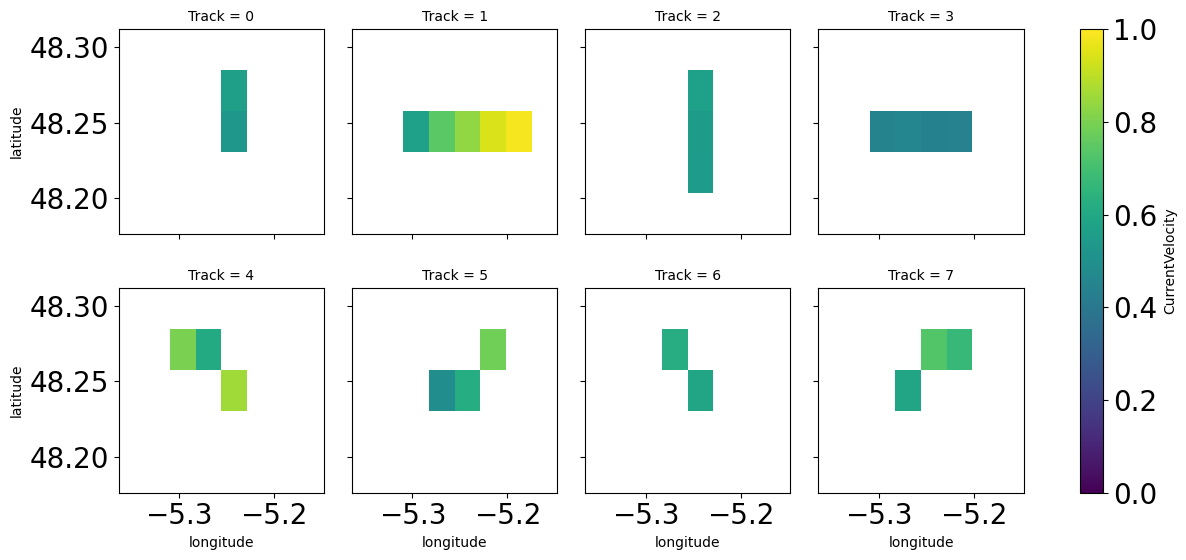

In [501]:
ds_star.CurrentVelocity.plot(col='Track', col_wrap=4,vmin=0, vmax=1)

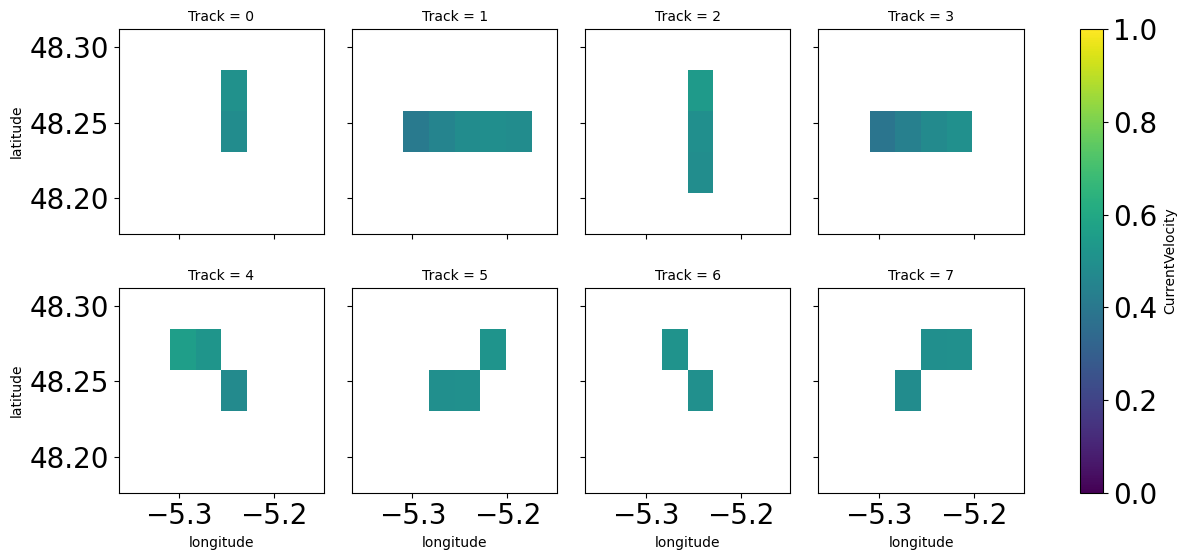

In [503]:
HF_CurrentVelocity.plot(col='Track', col_wrap=4,vmin=0, vmax=1)

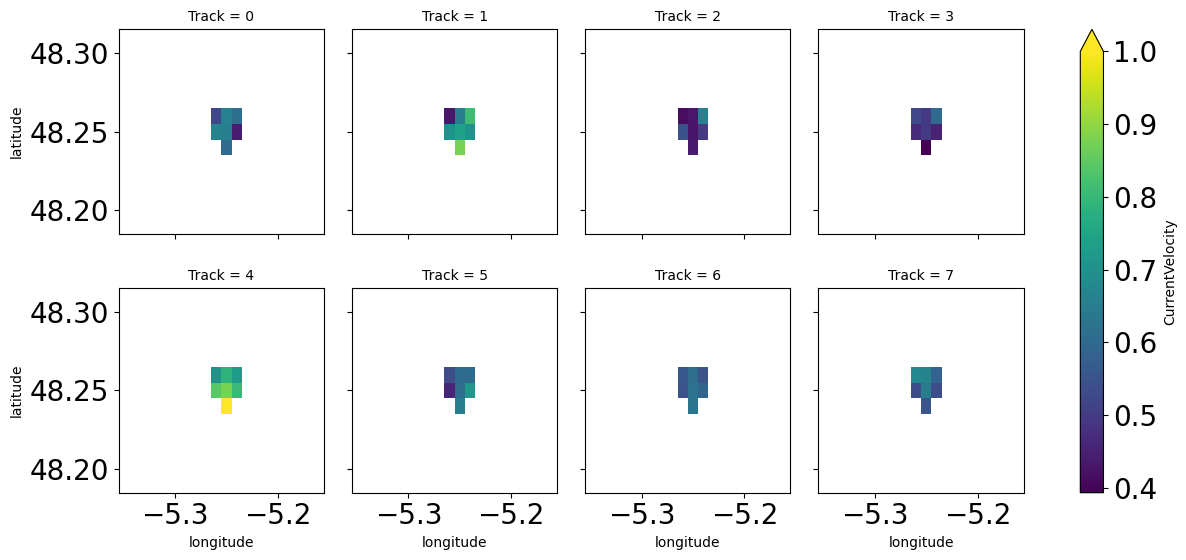

In [372]:
xr.where(np.isnan(ds_star).sum(dim='Track').CurrentVelocity==0,
         ds_star.CurrentVelocity,
         np.nan).plot(col='Track', col_wrap=4, vmax=1)

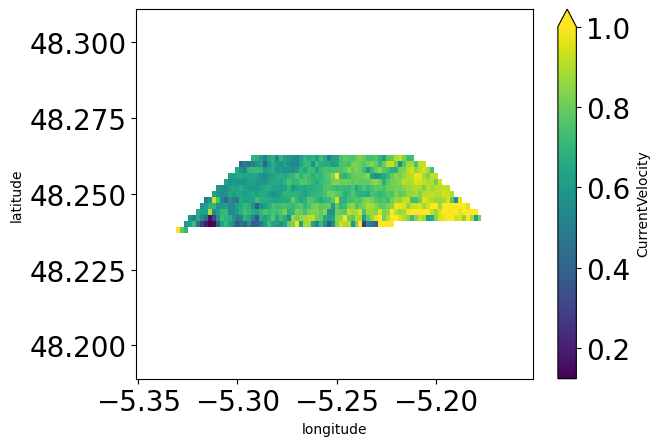

In [744]:
ds_star.sel(Track=1).CurrentVelocity.plot(vmax=1)

In [735]:
def RMS(x):
    return np.sqrt(np.mean(x ** 2))
def RMS_circ(x):
    return np.sqrt(np.rad2deg(sp.stats.circmean(np.deg2rad(x **2))))

In [719]:
ds_star.median(dim=['longitude','latitude']).CurrentVelocity

<xarray.DataArray 'CurrentVelocity' (Track: 8)>
array([0.54587333, 0.83432391, 0.55070686, 0.44469679, 0.80062753,
       0.62050551, 0.60462014, 0.67097146])
Dimensions without coordinates: Track

In [733]:
np.rad2deg(sp.stats.circmean(np.deg2rad(dir_oscar)))

14.405434282747434

In [730]:
dir_oscar = ds_star.median(dim=['longitude','latitude']).CurrentDirection
dir_err = np.abs(dir_oscar.data - cdir)

array([  9.14695824, 333.62928411, 335.61214063,  75.20758893,
        81.02671759, 340.08299573, 338.10097935,   5.24714318])

In [736]:
RMS_circ(dir_err)

16.653025149608386

In [737]:
print('Incidence angle range =', incidence_angle_min,'to',incidence_angle_max,'degrees')
print('GMF =',gmf)
print('─' * 50)
# good_tracks=[0,2,3,5,6,7]
good_tracks=[0,1,2,3,4,5,6,7]
# u = (aux_list['Trefle'].v_e.sel(time=ds_star.TrackTime, method='nearest').isel(bin=0).data
#                - aux_list['Trefle'].velocity_e.sel(time=ds_star.TrackTime, method='nearest').data).mean()
# v = (aux_list['Trefle'].v_n.sel(time=ds_star.TrackTime, method='nearest').isel(bin=0).data
#                - aux_list['Trefle'].velocity_n.sel(time=ds_star.TrackTime, method='nearest').data).mean()
u = (aux_list['Trefle2'].v_e.sel(time=ds_star.TrackTime, method='nearest').isel(bin=0).data).mean()
v = (aux_list['Trefle2'].v_n.sel(time=ds_star.TrackTime, method='nearest').isel(bin=0).data).mean()

RMSE_u = np.sqrt(((ds_star.median(dim=['longitude','latitude']).CurrentU.data - u)**2).mean())
RMSE_v = np.sqrt(((ds_star.median(dim=['longitude','latitude']).CurrentV.data - v)**2).mean())
cvel, cdir = ss.utils.tools.currentUV2VelDir(u,v)
# U_oscar = xr.where(np.isnan(ds_star).sum(dim='Track').CurrentVelocity==0,
#          ds_star.CurrentVelocity,
#          np.nan).median(dim=['longitude','latitude'])
U_oscar = ds_star.median(dim=['longitude','latitude']).CurrentVelocity
# dir_oscar = xr.where(np.isnan(ds_star).sum(dim='Track').CurrentDirection==0,
#          ds_star.CurrentDirection,
#          np.nan).median(dim=['longitude','latitude'])
dir_oscar = ds_star.median(dim=['longitude','latitude']).CurrentDirection
# RMSE_vel = np.sqrt(((ds_star.median(dim=['longitude','latitude']).CurrentVelocity.sel(Track=good_tracks).data - cvel)**2).mean())

RMSE_vel = RMS(U_oscar.sel(Track=good_tracks).data - cvel)

dir_err = np.abs(ds_star.median(dim=['longitude','latitude']).CurrentDirection.sel(Track=good_tracks).data - cdir)
# RMSE_deg = np.sqrt( np.median(np.where(dir_err > 180, np.mod(360 - dir_err, 360), dir_err)**2))
RMSE_deg = RMS_circ(dir_err)

HF_U = [None]*len(ds_star.Track)
HF_dir = [None]*len(ds_star.Track)
for i, track in enumerate(ds_L1c.keys()):
    t = ds_L1c[track].sel(Antenna='Mid').TrackTime
    HF_U[i] = aux_list['HF_combined'].sel(
        time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest'
    ).mean().CurrentVelocity.data
    HF_dir[i] = np.mod(aux_list['HF_combined'].sel(
        time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest'
    ).mean().CurrentDirection.data +180, 360)

RMSE_HF = RMS(U_oscar.sel(Track=good_tracks).data - np.mean(HF_U))
    
dir_err = dir_err = np.abs(dir_oscar - HF_dir)
RMSE_HF_deg = RMS(np.where(dir_err > 180, np.mod(360 - dir_err, 360), dir_err))





print('Retrieved Current Velocity =', np.round(U_oscar.mean().data,2),'m/s')
print('ADCP current velocity =',np.round(cvel,2),'m/s')
print('RMSE =', np.round(RMSE_vel,2),'m/s')
print('HF Radar Current Velocity =',np.round(np.mean(HF_U),2),'m/s')
print('RMSE =', np.round(RMSE_HF,2),'m/s')
print('─' * 50)
print('Retrieved Current Direction =', np.round(np.rad2deg(sp.stats.circmean(np.deg2rad(dir_oscar))),1),'deg')
print('ADCP current direction =',np.round(cdir,1),'deg')
print('RMSE =', np.round(RMSE_deg,1),'deg')
print('HF Radar current direction =', np.round(np.median(HF_dir),1),'deg')
print('RMSE =', np.round(RMSE_HF_deg,1),'deg')
print('─' * 50)
print('Retrieved U Velocity =', np.round(ds_star.mean().CurrentU.data,2),'m/s')
print('ADCP U velocity =', np.round(u, 2),'m/s')
print('RMSE U =', np.round(RMSE_u,2),'m/s')
print('Retrieved V Velocity =', np.round(ds_star.mean().CurrentV.data,2),'m/s')
print('ADCP V velocity =', np.round(v, 2),'m/s')
print('RMSE V =', np.round(RMSE_v,2),'m/s')
print('─' * 50)
wspd_err = np.array([float((ds_star.EarthRelativeWindSpeed.isel(Track=i) - wind_speed.T).mean().data)
                     for i in ds_star.Track])
RMSE_wspd = np.sqrt(np.mean(wspd_err**2))
wdir_err = np.array([float((ds_star.EarthRelativeWindDirection.isel(Track=i) - wind_direction.T).mean().data)
                     for i in ds_star.Track])
RMSE_wdir = np.sqrt( np.mean(np.where(wdir_err > 180, np.mod(360 - wdir_err, 360), wdir_err)**2))

print('Retrieved wind speed = ',np.round(ds_star.EarthRelativeWindSpeed.median().data, 2),'m/s')
print('AROME wind speed =', np.round(wind_speed.mean().data,2),'m/s')
print('RMSE = ', np.round(RMSE_wspd,2), 'm/s')
print('Retrieved wind direction = ',np.round(ds_star.EarthRelativeWindDirection.median().data, 2),'deg')
print('AROME wind direction =', np.round(wind_direction.mean(),2),'deg')
print('RMSE = ', np.round(RMSE_wdir,2), 'deg')
print('─' * 50)

Incidence angle range = 30 to 62 degrees
GMF = mouche12
──────────────────────────────────────────────────
Retrieved Current Velocity = 0.61 m/s
ADCP current velocity = 0.62 m/s
RMSE = 0.08 m/s
HF Radar Current Velocity = 0.5 m/s
RMSE = 0.14 m/s
──────────────────────────────────────────────────
Retrieved Current Direction = 14.4 deg
ADCP current direction = 8.4 deg
RMSE = 8.5 deg
HF Radar current direction = 325.4 deg
RMSE = 64.7 deg
──────────────────────────────────────────────────
Retrieved U Velocity = -0.02 m/s
ADCP U velocity = 0.09 m/s
RMSE U = 0.15 m/s
Retrieved V Velocity = 0.59 m/s
ADCP V velocity = 0.61 m/s
RMSE V = 0.08 m/s
──────────────────────────────────────────────────


ValueError: operands could not be broadcast together with shapes (61,100) (5,8) 

In [154]:
HF_U = [None]*len(ds_star.Track)
HF_dir = [None]*len(ds_star.Track)
for i, track in enumerate(ds_L1c.keys()):
    t = ds_L1c[track].sel(Antenna='Mid').TrackTime
    HF_U[i] = aux_list['HF_combined'].sel(
        time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest'
    ).mean().CurrentVelocity.data
    HF_dir[i] = np.mod(aux_list['HF_combined'].sel(
        time=ds_L1c[track].sel(Antenna='Mid').TrackTime,method='nearest'
    ).mean().CurrentDirection.data +180, 360)

# Plot Star Pattern map

In [161]:
np.sqrt(np.mean((ds_star.median(dim=['longitude','latitude']).CurrentVelocity.data - HF_U) **2))

0.1398745836992936

C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\davidmccann\anaconda3\envs\seastar\lib\site-packages\cartopy\crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


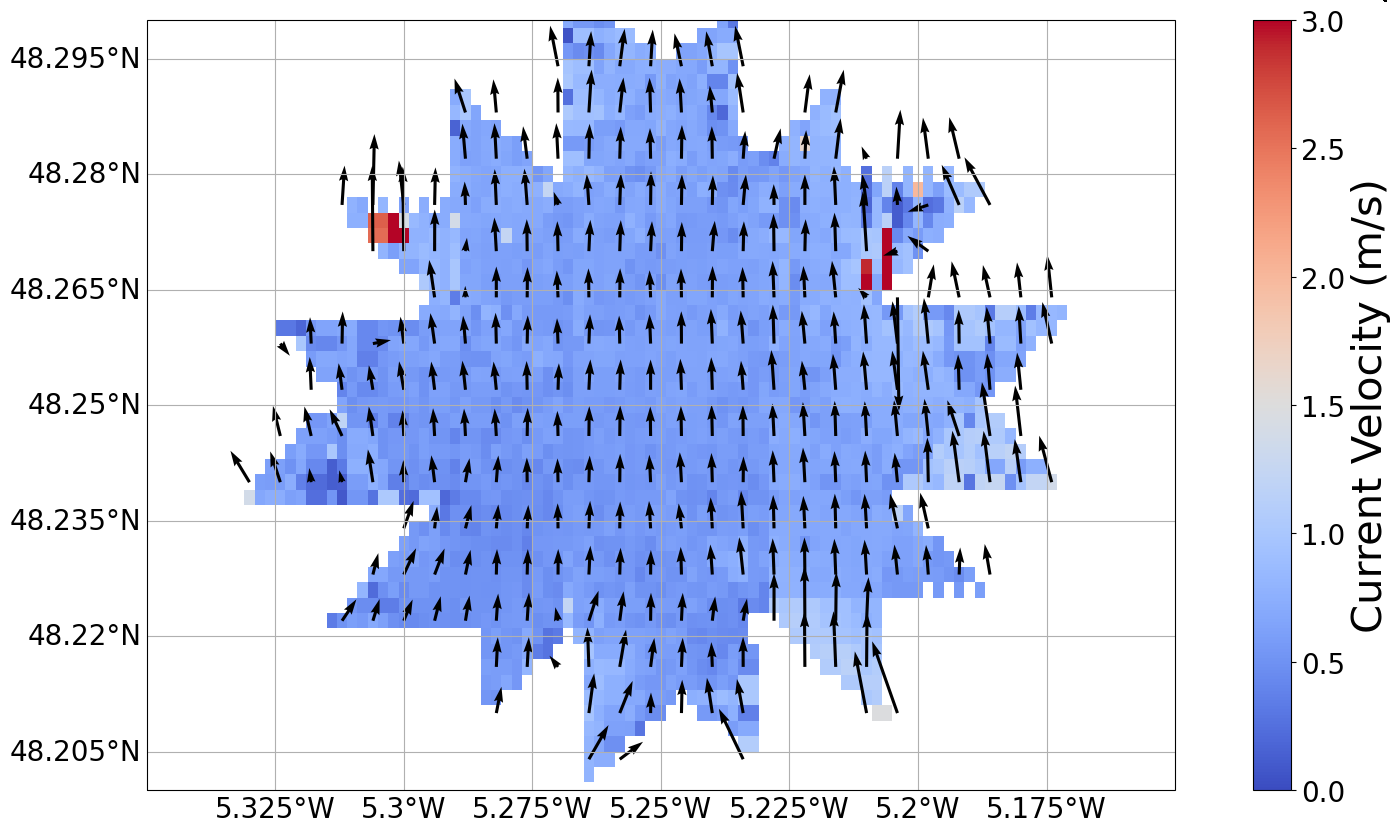

In [56]:
var = 2
var_to_plot = {1:'EarthRelativeWindSpeed',2:'CurrentVelocity'}[var]
grid = 'close'
extent = {'wide':[-5.4, -5, 48.1, 48.5],
         'close':[-5.35, -5.15, 48.2, 48.3]}[grid]
plot_buoy = False
if var_to_plot=='CurrentVelocity':
    vmax = 3
    q_factor = 2 # Quiver plot posting factor
    q_scale = 20
elif var_to_plot in ['EarthRelativeWindSpeed','OceanSurfaceWindSpeed']:
    vmax = 10
    q_factor = 2 # Quiver plot posting factor
    q_scale = 180 # Quiver plot scaling factor
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
im=ds_star[var_to_plot].median(dim='Track').plot(vmin=0,vmax=vmax,
                                               add_colorbar=False,
                                               cmap='coolwarm',
                                               transform=ccrs.PlateCarree())
ds_star.mean(dim='Track')\
    .coarsen(longitude=q_factor,boundary='trim').mean().coarsen(latitude=q_factor,boundary='trim').mean()\
    .plot.quiver(
    x='longitude',
    y='latitude',
    u=var_to_plot.replace('Velocity','U').replace('Speed','U'),
    v=var_to_plot.replace('Velocity','V').replace('Speed','V'),
    scale=q_scale,width=0.003,
    angles='xy',
    pivot='tail',
    robust=True,
    transform=ccrs.PlateCarree(),
    color='k',
)

if plot_buoy:
    plt.scatter(aux_list['Trefle'].longitude.mean(),
                aux_list['Trefle'].latitude.mean(),
               c='r',
               marker='^',
                s=200,
               transform=ccrs.PlateCarree(),
               label='Trefle buoy')
    plt.legend()
gl=ax.gridlines(draw_labels=True)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'), linewidth=2)
gl.top_labels=False
gl.right_labels=False
cbar = plt.colorbar(im,ax=ax)
cbar.set_label([re.sub(r"(\w)([A-Z])", r"\1 \2", ele) for ele in [var_to_plot]][0] + ' (m/s)',fontsize=30)

In [162]:
dir_err = ds_star.median(dim=['longitude','latitude']).CurrentDirection.data - HF_dir
np.sqrt( np.median(np.where(dir_err > 180, np.mod(360 - dir_err, 360), dir_err)**2))

16.44968985449194

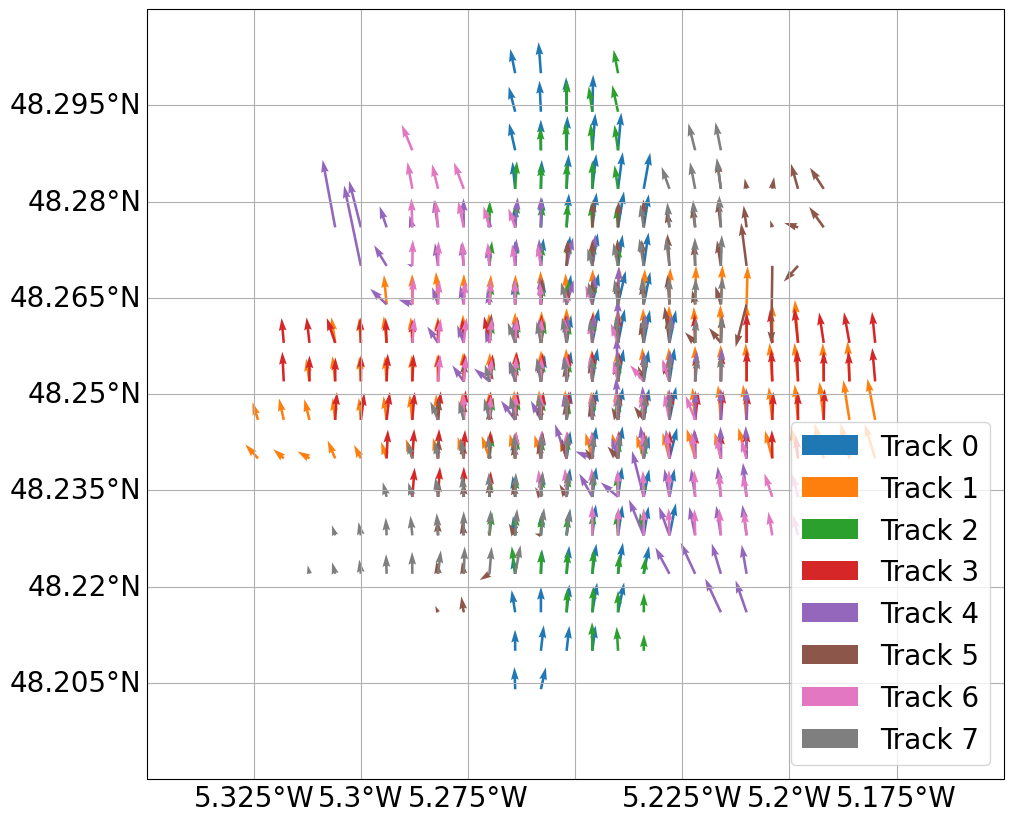

In [79]:
colors=['C0','C1','C2','C3','C4','C5','C6','C7']

q_factor=3
q_scale=20
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
for track in list(ds_star.Track.data):
    ds_star.sel(Track=track)\
    .coarsen(longitude=q_factor,boundary='trim').mean().coarsen(latitude=q_factor,boundary='trim').mean()\
    .plot.quiver(
    x='longitude',y='latitude',
    u='CurrentU',v='CurrentV',
    scale=q_scale,width=0.003,
    angles='xy',pivot='tail',
    robust=True,
    transform=ccrs.PlateCarree(),
    color=colors[track], label='Track '+str(track)
)
plt.legend(loc='lower right')
# plt.colorbar()
gl=ax.gridlines(draw_labels=True)
ax.set_extent(extent, crs=ccrs.PlateCarree())
gl.top_labels=False
gl.right_labels=False

In [630]:
aux_list['Trefle2'] = xr.open_dataset(file_paths['aux_path'] + folder + 'TREFLE_WH300_avg_v2.nc')
aux_list['Trefle2'] = aux_list['Trefle2'].assign_coords(depth=("bin", aux_list['Trefle2'].depth.data))

(19132.0, 19136.0)

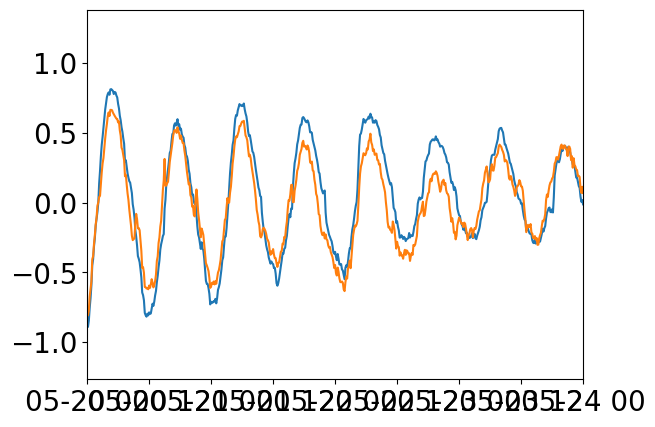

In [648]:
plt.plot(aux_list['Trefle2'].time,aux_list['Trefle2'].v_n.isel(bin=0))
plt.plot(aux_list['Trefle'].time,aux_list['Trefle'].v_n.isel(bin=0))
plt.xlim([np.datetime64('2022-05-20'),np.datetime64('2022-05-24')])

In [ ]:
aux_list['Trefle2'].sel(time=np.datetime64('2022-05-22T06'), method='nearest').v_e

In [706]:
t

<xarray.DataArray 'TrackTime' ()>
array('2022-05-22T06:20:18.000000000', dtype='datetime64[ns]')
Coordinates:
    Antenna  <U3 'Mid'

In [705]:
aux_list['Trefle2'].sel(time=t, method='nearest').v_e

<xarray.DataArray 'v_e' (bin: 80)>
array([ 0.098582,  0.105431,  0.108561,  0.100701,  0.100672,  0.092199,
        0.086577,  0.085306,  0.091111,  0.092706,  0.06735 ,  0.043421,
        0.019704,  0.016131,  0.018548,  0.017018,  0.017189,  0.026302,
        0.034939,  0.041632,  0.0515  ,  0.043782,  0.051467,  0.04741 ,
        0.041153,  0.02872 ,  0.028239,  0.028952,  0.020353,  0.016885,
        0.00668 , -0.002025,  0.014367,  0.006945,  0.007709,  0.014082,
        0.022713,  0.01051 ,  0.010706,  0.007431,  0.014439,  0.01691 ,
        0.011031,  0.016755,  0.023526,  0.030222,  0.029431,  0.033027,
        0.03753 ,  0.040581,  0.042129,  0.055731,  0.061079,  0.071399,
        0.087366,  0.089832,  0.104482,  0.115387,  0.1125  ,  0.123697,
        0.124531,  0.118279,  0.127552,  0.130623,  0.123047,  0.127091,
        0.134721,  0.140479,  0.135628,  0.133508,  0.142153,  0.149884,
        0.143912,  0.149558,  0.149747,  0.140583,  0.146292,  0.128048,
        0.116094,  0.089297], dtype=float32)
Coordinates:
    time     datetime64[ns] 2022-05-22T06:20:00
    depth    (bin) float32 3.0 4.0 5.0 6.0 7.0 8.0 ... 78.0 79.0 80.0 81.0 82.0
    Antenna  <U3 'Mid'
Dimensions without coordinates: bin
Attributes:
    long_name:  eastward component of current velocity
    units:      m/s

Text(0.5, 0, 'Current velocity (m/s)')

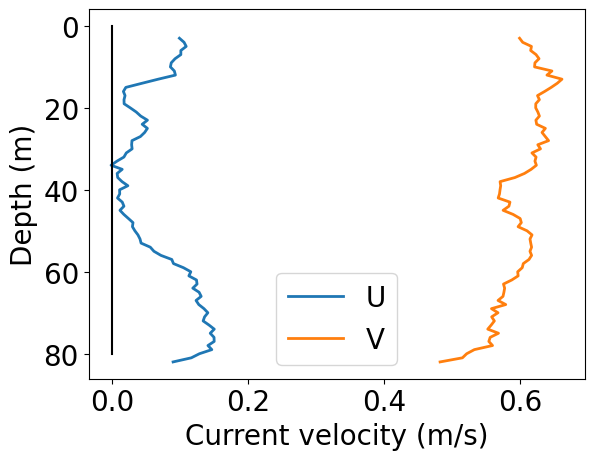

In [750]:
# for track in ds_L2.keys():
for track in ['Track_11']:
    t = ds_L1c[track].TrackTime.sel(Antenna='Mid')
    plt.plot(aux_list['Trefle2'].sel(time=t, method='nearest').v_e,
         aux_list['Trefle2'].sel(time=t, method='nearest').depth,
        label='U', linewidth=2,c='C0')
    plt.plot(aux_list['Trefle2'].sel(time=t, method='nearest').v_n,
         aux_list['Trefle2'].sel(time=t, method='nearest').depth,
        label='V', linewidth=2,c='C1')
plt.plot([0,0],[0,80],'k')
plt.gca().invert_yaxis()
# plt.gca().set_yscale('log')
plt.legend()
plt.ylabel('Depth (m)', fontsize=20)
plt.xlabel('Current velocity (m/s)', fontsize=20)

In [682]:
from scipy.optimize import curve_fit
def fit_func(d, A, B, C, f):
    g = (A * d**3) + (B * d**2) + (C * d) + f
    return(g.ravel())
popt, pcov = curve_fit(fit_func,
                       aux_list['Trefle2'].sel(time=t, method='nearest').depth.data,
                       aux_list['Trefle2'].sel(time=t, method='nearest').v_e.data
                      )

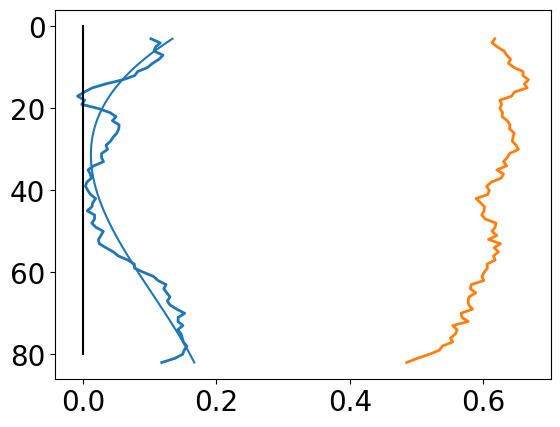

In [683]:
for track in ['Track_12']:
    t = ds_L1c[track].TrackTime.sel(Antenna='Mid')
    plt.plot(aux_list['Trefle2'].sel(time=t, method='nearest').v_e,
         aux_list['Trefle2'].sel(time=t, method='nearest').depth,
        label='U', linewidth=2,c='C0')
    plt.plot(aux_list['Trefle2'].sel(time=t, method='nearest').v_n,
         aux_list['Trefle2'].sel(time=t, method='nearest').depth,
        label='V', linewidth=2,c='C1')
plt.plot([0,0],[0,80],'k')
plt.gca().invert_yaxis()


plt.plot(fit_func(aux_list['Trefle2'].sel(time=t, method='nearest').depth.data, *popt),
         aux_list['Trefle2'].sel(time=t, method='nearest').depth.data,
         c='C0')

In [687]:
aux_list['Trefle2'].sel(time=t, method='nearest').v_n.mean()

<xarray.DataArray 'v_n' ()>
array(0.6087183, dtype=float32)
Coordinates:
    time     datetime64[ns] 2022-05-22T06:30:00
    Antenna  <U3 'Mid'